# Team Introduction
Our group is comprised of Braden Anderson, Hien Lam, and Tavin Weeda.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
# from lightgbm import LGBMClassifier
from scipy import stats

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.model_selection import  train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import MiniBatchKMeans, DBSCAN

# Business Understanding 1
- Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). 
- How will you measure the effectiveness of a good algorithm? 
- Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?  
(10)

**Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?).**

Crash Report Sampling System (CRSS) is a probability sample of police-reported traffic crashes used to analyze crash trends and promote highway safety measures as well as public information initiatives. The 2020 data encompassing driver-related, vehicular accidents was obtained. Our goal is to elucidate factors that contribute to crashes as they relate to the driver, vehicle, road infrastructure, and environment in order to effectively reduce/prevent accidents.

**How will you measure the effectiveness of a good algorithm?**

The effectiveness of a good cluster is contingent on discernable clusters that allow for insights to be extracted.

**Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?**

Words

# Data Understanding 1
- Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. 
- Verify data quality: Are there missing values? 
- Duplicate data? Outliers? Are those mistakes? 
- How do you deal with these problems?  
(10)

**Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file.**

Below is a table containing all features (original, carefully binned, or derived), brief description, and type of data (scaled, hot encoded, ordinal encoded).

**Verify data quality: Are there missing values?**

Each observation corresponded to a driver from a unique accident, as noted under `casenum`. Due to the reliance of information contained in police reports, missing values were present with the `unreported` or `unknown` designation. We binned them together prior to hot encoding the categorical features. The most concerning feature was `trav_sp` (traveling vehicle speed) which we later imputed. 

**Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?**

We cared for duplicated data in two ways: 
1) Dropped duplicate `casenum` during the initial merging of three datasets
2) Checked for duplicates of instances where `casenum` was excluded

Step one ensured that the integrity of each unique accident was preserved. Step two was a sanity check and confirmed there were zero duplicate observations. 

Most of the outliers encountered were scant distributed among both extremes of categorical levels. We dealt with this by binning similar levels together to ensure the integrity of the data. Outliers from the continuous features were removed as they were not representative of our population. Specifically, we filtered age of driver to be between 16-100 and removed vehicle year below 1980. We will note age 120 was lone observation above the age of 100, and we surmised it could be a recording error (meant to be 20 years old but inputted as 120).

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)
table = [
    ['age_im', "driver's age at time of crash, in years, with respect to their last birthday", 'int'],
    ['maxsev_binned', 'severity of injury sustained by the driver', 'object'],
    ['mod_yearname_x', 'vehicle model year', 'int'],
    ['ordinal_encoder__urbanicityname', 'geographical area of the crash', 'ordinal encoded'],
    ['ordinal_encoder__alchl_imname', "driver's alcohol use", 'ordinal encoded'],
    ['ordinal_encoder__reljct1_imname', "crash's location with respect to presence in or proximity to junction or interchange areas", 'ordinal encoded'],
    ['ordinal_encoder__int_hwyname', 'Whether accident took place at an intersection', 'ordinal encoded'],
    ['ordinal_encoder__sex_imname', 'Gender of driver', 'ordinal encoded'],
    ['one_hot_encoder__hour_binned_Morning', 'Time of accident', 'one hot encoded'],
    ['one_hot_encoder__hour_binned_Night', 'Time of accident', 'one hot encoded'],
    ['one_hot_encoder__hour_binned_Afternoon', 'Time of accident', 'one hot encoded'],
    ['one_hot_encoder__hour_binned_Evening', 'Time of accident', 'one hot encoded'],
    ['one_hot_encoder__intersection_binned_Yes', 'Whether accident took place at an intersection', 'one hot encoded'],
    ['one_hot_encoder__intersection_binned_No', 'Whether accident took place at an intersection', 'one hot encoded'],
    ['one_hot_encoder__intersection_binned_Other', 'Whether accident took place at an intersection', 'one hot encoded'],
    ['one_hot_encoder__lgtcon_imname_Daylight', 'type/level of light at time of crash', 'one hot encoded'],
    ['one_hot_encoder__lgtcon_imname_Dark - Not Lighted', 'type/level of light at time of crash', 'one hot encoded'],
    ['one_hot_encoder__lgtcon_imname_Dawn', 'type/level of light at time of crash', 'one hot encoded'],
    ['one_hot_encoder__lgtcon_imname_Dark - Lighted', 'type/level of light at time of crash', 'one hot encoded'],
    ['one_hot_encoder__lgtcon_imname_Dark - Unknown Lighting', 'type/level of light at time of crash', 'one hot encoded'],
    ['one_hot_encoder__lgtcon_imname_Dusk', 'type/level of light at time of crash', 'one hot encoded'],
    ['one_hot_encoder__lgtcon_imname_Other', 'type/level of light at time of crash', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Going Straight', "Driver's pre-event movenent prior to recognition of critical event", 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Negotiating a Curve', "Driver's pre-event movenent prior to recognition of critical event", 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Stopped in Roadway', "Driver's pre-event movenent prior to recognition of critical event", 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Turning Right', "Driver's pre-event movenent prior to recognition of critical event", 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Turning Left', "Driver's pre-event movenent prior to recognition of critical event", 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Starting in Road', "Driver's pre-event movenent prior to recognition of critical event", 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Changing Lanes', "Driver's pre-event movenent prior to recognition of critical event", 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Decelerating in Road', "Driver's pre-event movenent prior to recognition of critical event", 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Passing or Overtaking Another Vehicle', "Driver's pre-event movenent prior to recognition of critical event", 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Backing Up (other than for Parking Position)', "Driver's pre-event movenent prior to recognition of critical event", 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Making a U-turn', "Driver's pre-event movenent prior to recognition of critical event", 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Accelerating in Road', "Driver's pre-event movenent prior to recognition of critical event", 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Disabled or "Parked" in Travel lane', "Driver's pre-event movenent prior to recognition of critical event", 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Leaving a Parking Position', "Driver's pre-event movenent prior to recognition of critical event", 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Merging', "Driver's pre-event movenent prior to recognition of critical event", 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Entering a Parking Position', "Driver's pre-event movenent prior to recognition of critical event", 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Other(specify:)', "Driver's pre-event movenent prior to recognition of critical event", 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Successful Avoidance Maneuver to a Previous Critical Event', "Driver's pre-event movenent prior to recognition of critical event", 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_No Driver Present / Unknown if Driver Present', "Driver's pre-event movenent prior to recognition of critical event", 'one hot encoded'],
    ['one_hot_encoder__regionname_West' 'one_hot_encoder__regionname_South', 'where crash occurred', 'one hot encoded'],
    ['one_hot_encoder__regionname_Northeast', 'where crash occurred', 'one hot encoded'],
    ['one_hot_encoder__regionname_Midwest', 'where crash occurred', 'one hot encoded'],
    ['one_hot_encoder__regionname_South', 'where crash occurred', 'one hot encoded'],
    ['one_hot_encoder__restraint_binned_Full', 'Restraint equipment used by driver', 'one hot encoded'],
    ['one_hot_encoder__restraint_binned_Other', 'Restraint equipment used by driver', 'one hot encoded'],
    ['one_hot_encoder__restraint_binned_None', 'Restraint equipment used by driver', 'one hot encoded'],
    ['one_hot_encoder__restraint_binned_Minimal', 'Restraint equipment used by driver', 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_Traffic control signal(on colors) not known whether or not Pedestrian Signal', "traffic controls in the vehicle’s environment just prior to crash", 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_No Controls', "traffic controls in the vehicle’s environment just prior to crash", 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_Warning Sign', "traffic controls in the vehicle’s environment just prior to crash", 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_NR/UNK/OTH', "traffic controls in the vehicle’s environment just prior to crash", 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_Stop Sign', "traffic controls in the vehicle’s environment just prior to crash", 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_Traffic control signal (on colors) without Pedestrian Signal', "traffic controls in the vehicle’s environment just prior to crash", 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_Traffic control signal (on colors) with Pedestrian Signal', "traffic controls in the vehicle’s environment just prior to crash", 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_Railway Crossing Device', "traffic controls in the vehicle’s environment just prior to crash", 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_Yield Sign', "traffic controls in the vehicle’s environment just prior to crash", 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_Flashing Traffic Control Signal', "traffic controls in the vehicle’s environment just prior to crash", 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_Person', "traffic controls in the vehicle’s environment just prior to crash", 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_School Zone Sign/Device', "traffic controls in the vehicle’s environment just prior to crash", 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_Lane Use Control Signal', "traffic controls in the vehicle’s environment just prior to crash", 'one hot encoded'],
    ['one_hot_encoder__vtrafwayname_Two-Way, Not Divided', 'trafficway flow just prior to crash', 'one hot encoded'],
    ['one_hot_encoder__vtrafwayname_Two-Way,  Divided, Positive  Median Barrier', 'trafficway flow just prior to crash', 'one hot encoded'],
    ['one_hot_encoder__vtrafwayname_NR/UNK', 'trafficway flow just prior to crash', 'one hot encoded'],
    ['one_hot_encoder__vtrafwayname_Entrance/Exit Ramp', 'trafficway flow just prior to crash', 'one hot encoded'],
    ['one_hot_encoder__vtrafwayname_Two-Way, Divided, Unprotected Median', 'trafficway flow just prior to crash', 'one hot encoded'],
    ['one_hot_encoder__vtrafwayname_One-Way Trafficway', 'trafficway flow just prior to crash', 'one hot encoded'],
    ['one_hot_encoder__vtrafwayname_Two-Way, Not Divided With a Continuous Left-Turn Lane', 'trafficway flow just prior to crash', 'one hot encoded'],
    ['one_hot_encoder__vtrafwayname_Non-Trafficway or Driveway Access', 'trafficway flow just prior to crash', 'one hot encoded'],
    ['one_hot_encoder__weather_binned_Not Clear', 'prevailing atmospheric conditions at the time of the crash', 'one hot encoded'],
    ['one_hot_encoder__weather_binned_Clear', 'prevailing atmospheric conditions at the time of the crash', 'one hot encoded'],
    ['one_hot_encoder__weather_binned_Wintery', 'prevailing atmospheric conditions at the time of the crash', 'one hot encoded'],
    ['one_hot_encoder__weather_binned_Other', 'prevailing atmospheric conditions at the time of the crash', 'one hot encoded'],
    ['one_hot_encoder__weather_binned_Rain', 'prevailing atmospheric conditions at the time of the crash', 'one hot encoded'],
    ['one_hot_encoder__weather_binned_Windy', 'prevailing atmospheric conditions at the time of the crash', 'one hot encoded'],
    ['one_hot_encoder__wkdy_imname_Wednesday', 'day of week at time of the crash', 'one hot encoded'],
    ['one_hot_encoder__wkdy_imname_Friday', 'day of week at time of the crash', 'one hot encoded'],
    ['one_hot_encoder__wkdy_imname_Thursday', 'day of week at time of the crash', 'one hot encoded'],
    ['one_hot_encoder__wkdy_imname_Saturday', 'day of week at time of the crash', 'one hot encoded'],
    ['one_hot_encoder__wkdy_imname_Sunday', 'day of week at time of the crash', 'one hot encoded'],
    ['one_hot_encoder__wkdy_imname_Monday', 'day of week at time of the crash', 'one hot encoded'],
    ['one_hot_encoder__wkdy_imname_Tuesday', 'day of week at time of the crash', 'one hot encoded'],
    ['one_hot_encoder__vnum_lanname_Five lanes', 'number of travel lanes just prior to crash. Median: lanes in opposite directions are additive. No median: lanes in traveling direction counts', 'one hot encoded'],
    ['one_hot_encoder__vnum_lanname_Two lanes', 'number of travel lanes just prior to crash. Median: lanes in opposite directions are additive. No median: lanes in traveling direction counts', 'one hot encoded'],
    ['one_hot_encoder__vnum_lanname_NR/UNK', 'number of travel lanes just prior to crash. Median: lanes in opposite directions are additive. No median: lanes in traveling direction counts', 'one hot encoded'],
    ['one_hot_encoder__vnum_lanname_Three lanes', 'number of travel lanes just prior to crash. Median: lanes in opposite directions are additive. No median: lanes in traveling direction counts', 'one hot encoded'],
    ['one_hot_encoder__vnum_lanname_Four lanes', 'number of travel lanes just prior to crash. Median: lanes in opposite directions are additive. No median: lanes in traveling direction counts', 'one hot encoded'],
    ['one_hot_encoder__vnum_lanname_Six lanes', 'number of travel lanes just prior to crash. Median: lanes in opposite directions are additive. No median: lanes in traveling direction counts', 'one hot encoded'],
    ['one_hot_encoder__vnum_lanname_Non-Trafficway or Driveway Access', 'number of travel lanes just prior to crash. Median: lanes in opposite directions are additive. No median: lanes in traveling direction counts', 'one hot encoded'],
    ['one_hot_encoder__vnum_lanname_Seven or more lanes', 'number of travel lanes just prior to crash. Median: lanes in opposite directions are additive. No median: lanes in traveling direction counts', 'one hot encoded'],
    ['one_hot_encoder__vnum_lanname_One lane', 'number of travel lanes just prior to crash. Median: lanes in opposite directions are additive. No median: lanes in traveling direction counts', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_Snow', 'roadway surface condition just prior to crash', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_Dry', 'roadway surface condition just prior to crash', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_NR/UNK/OTH', 'roadway surface condition just prior to crash', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_Wet', 'roadway surface condition just prior to crash', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_Non-Trafficway or Driveway Access', 'roadway surface condition just prior to crash', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_Ice/Frost', 'roadway surface condition just prior to crash', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_Water (Standing or Moving)', 'roadway surface condition just prior to crash', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_Slush', 'roadway surface condition just prior to crash', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_Sand', 'roadway surface condition just prior to crash', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_Mud, Dirt or Gravel', 'roadway surface condition just prior to crash', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_Oil', 'roadway surface condition just prior to crash', 'one hot encoded'],
    ['one_hot_encoder__speeding_status_unknown', 'driver behavior relative to speed', 'one hot encoded'],
    ['one_hot_encoder__speeding_status_speeding', 'driver behavior relative to speed', 'one hot encoded'],
    ['one_hot_encoder__speeding_status_not speeding', 'driver behavior relative to speed', 'one hot encoded'],
    ['one_hot_encoder__body_type_binned_1', 'vehicle classification based on its body configuration, size, shape, doors', 'one hot encoded'],
    ['one_hot_encoder__body_type_binned_2', 'vehicle classification based on its body configuration, size, shape, doors', 'one hot encoded'],
    ['one_hot_encoder__body_type_binned_6', 'vehicle classification based on its body configuration, size, shape, doors', 'one hot encoded'],
    ['one_hot_encoder__body_type_binned_3', 'vehicle classification based on its body configuration, size, shape, doors', 'one hot encoded'],
    ['one_hot_encoder__body_type_binned_9', 'vehicle classification based on its body configuration, size, shape, doors', 'one hot encoded'],
    ['one_hot_encoder__body_type_binned_12', 'vehicle classification based on its body configuration, size, shape, doors', 'one hot encoded'],
    ['one_hot_encoder__body_type_binned_7', 'vehicle classification based on its body configuration, size, shape, doors', 'one hot encoded'],
    ['one_hot_encoder__body_type_binned_10', 'vehicle classification based on its body configuration, size, shape, doors', 'one hot encoded'],
    ['one_hot_encoder__body_type_binned_4', 'vehicle classification based on its body configuration, size, shape, doors', 'one hot encoded'],
    ['one_hot_encoder__body_type_binned_11', 'vehicle classification based on its body configuration, size, shape, doors', 'one hot encoded'],
    ['one_hot_encoder__body_type_binned_5', 'vehicle classification based on its body configuration, size, shape, doors', 'one hot encoded'],
    ['one_hot_encoder__body_type_binned_8', 'vehicle classification based on its body configuration, size, shape, doors', 'one hot encoded'],
    ['trav_sp_scaled', 'speed of the vehicle prior to crash occurrence as reported by the officer', 'float, scaled']
]
table = pd.DataFrame(table, columns=['Feature', 'Description', 'Representation'])
table

,Feature,Description,Representation
0,age_im,"driver's age at time of crash, in years, with respect to their last birthday",int
1,maxsev_binned,severity of injury sustained by the driver,object
2,mod_yearname_x,vehicle model year,int
3,ordinal_encoder__urbanicityname,geographical area of the crash,ordinal encoded
4,ordinal_encoder__alchl_imname,driver's alcohol use,ordinal encoded
5,ordinal_encoder__reljct1_imname,crash's location with respect to presence in or proximity to junction or interchange areas,ordinal encoded
6,ordinal_encoder__int_hwyname,Whether accident took place at an intersection,ordinal encoded
7,ordinal_encoder__sex_imname,Gender of driver,ordinal encoded
8,one_hot_encoder__hour_binned_Morning,Time of accident,one hot encoded
9,one_hot_encoder__hour_binned_Night,Time of accident,one hot encoded


In [3]:
pd.reset_option("display.max_columns")
pd.reset_option("display.max_rows")

## Comprehensive Data Cleaning Steps
1. Read, merged, filtered the data (54427 rows, 24 columns) then dealt with missing values to result in (54473, 24)
2. Inspected each feature, noted cleaning steps if necessary (features from lab 1 only)
3. Carefully binned existing features (`body_type_binned`, `intersection_binned`, `weather_binned`)
4. Derived new features (`speeding_status`, `hour_binned`, `restraint_binned`, `pcrash1_imname`)
5. Binned and visualized response variable for classification task, `maxsev_binned`
6. Visualized response variable for regression task, `age_im`
7. Confirmed there are zero duplicates and NA values (50535, 24)
8. Conducted data preprocessing: 
  - Split full dataset into 80% train / 20% test, performed 10 fold stratified cross validation within the 80% train set.
  - Scaled `age_im` and `mod_yearname_x` on train and test data separately (ensured transformer was only fit on the train set to prevent data leakage)
  - Ordinal and one hot encoded features on train and test data separately
  - Imputed and scaled `trav_sp` on train and test data separately (ensured transformer was only fit on the train set to prevent data leakage)
9. Removed variables that were not needed/useful: 
  - `makename` (too many levels), 
  - `wrk_zonename` (99% of one class)
  - `hour_imname` (unnecessary with `hour_binned`)
  - `vspd_lim` (unnecessary with `speeding_status`) 
  - `body_type_x` (unnecessary with `body_type_binned`)
  - `weathername` (unecessary with `weather_binned`)
  - `typ_intname` (unnecessary with `intersection_binned`)
  - `maxsev_imname` (unnecessary with `maxsev_binned`)
  - `trav_sp` (unnecessary with `trav_sp_imputed`)
10. Final dataset dimension 50535 rows, 119 columns (prior to train/test split)

## Read, clean the data

In [4]:
# Read in data from github
url_accident = "https://github.com/BradenAnderson/Accident_Severity_Prediction/blob/main/Data/accident.csv.gz?raw=tr"
url_vehicle = "https://github.com/BradenAnderson/Accident_Severity_Prediction/blob/main/Data/vehicle.csv.gz?raw=tr"
url_person = "https://github.com/BradenAnderson/Accident_Severity_Prediction/blob/main/Data/person.csv.gz?raw=tr"

accident = pd.read_csv(url_accident,compression='gzip')
vehicle = pd.read_csv(url_vehicle, compression='gzip', low_memory=False, encoding="ISO-8859-1")
person = pd.read_csv(url_person, compression='gzip', low_memory=False, encoding="ISO-8859-1")

In [5]:
# Filter accidents where driver is present and vehicle is involved
person = person.loc[(person.VEH_NO==1) & (person.PER_NO==1)]
vehicle = vehicle.loc[vehicle.VEH_NO==1]

In [6]:
# Left join person with vehicle and accident
# Duplicated CASENUM are dropped
df = person.merge(vehicle.drop_duplicates(subset=['CASENUM']), on='CASENUM', how='left')
df = df.merge(accident.drop_duplicates(subset=['CASENUM']),on='CASENUM',how='left')

In [7]:
# Comprehensive list of variables used in this analysis
# ORIGINAL features from lab 1 / EDA: regionname, urbanicityname, body_typname, makename, mod_yearname, vtrafwayname, vnum_lanname, vsurcondname, vtrafconname, 
                                # typ_intname, int_hwyname, weathername, wkdy_imname, reljct1_imname, lgtcon_imname, maxsev_imname, alchl_imname, age_im, sex_imname, trav_sp
# DERIVED features: hour_binned, speeding_status
# NEW features post-lab 1 / EDA: rest_usename, pcrash1_imname, weather_binned (binning of `weathername`), body_type_binned (binning of `body_typname`), int_binned (binning of `typ_intname`)
# DISCARDED features that were not useful: hour_imname (unnecessary with `hour_binned`), vspd_lim (unnecessary with `speeding_status`), makename (too many levels), wrk_zonename

df = df[['REGIONNAME','URBANICITYNAME','BODY_TYPNAME_x', 'MOD_YEARNAME_x','VTRAFWAYNAME','VNUM_LANNAME','VSURCONDNAME','VTRAFCONNAME','TYP_INTNAME','INT_HWYNAME','WEATHERNAME',
        'WKDY_IMNAME', 'RELJCT1_IMNAME','LGTCON_IMNAME','MAXSEV_IMNAME','ALCHL_IMNAME','AGE_IM','SEX_IMNAME','TRAV_SP','REST_USENAME','PCRASH1_IMNAME','HOUR_IMNAME','VSPD_LIM',
        'HOUR_IM']]

df = df.rename(columns=str.lower)
df.shape

(54473, 24)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54473 entries, 0 to 54472
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   regionname      54473 non-null  object 
 1   urbanicityname  54473 non-null  object 
 2   body_typname_x  54473 non-null  object 
 3   mod_yearname_x  54473 non-null  object 
 4   vtrafwayname    54427 non-null  object 
 5   vnum_lanname    54427 non-null  object 
 6   vsurcondname    54427 non-null  object 
 7   vtrafconname    54427 non-null  object 
 8   typ_intname     54473 non-null  object 
 9   int_hwyname     54473 non-null  object 
 10  weathername     54473 non-null  object 
 11  wkdy_imname     54473 non-null  object 
 12  reljct1_imname  54473 non-null  object 
 13  lgtcon_imname   54473 non-null  object 
 14  maxsev_imname   54473 non-null  object 
 15  alchl_imname    54473 non-null  object 
 16  age_im          54473 non-null  int64  
 17  sex_imname      54473 non-null 

In [9]:
df.head()

,regionname,urbanicityname,body_typname_x,mod_yearname_x,vtrafwayname,vnum_lanname,vsurcondname,vtrafconname,typ_intname,int_hwyname,...,maxsev_imname,alchl_imname,age_im,sex_imname,trav_sp,rest_usename,pcrash1_imname,hour_imname,vspd_lim,hour_im
0,"West (MT, ID, WA, OR, CA, NV, NM, AZ, UT, CO, WY, AK, HI)",Rural Area,"4-door sedan, hardtop",2018,"Two-Way, Not Divided",Five lanes,Snow,Traffic control signal(on colors) not known whether or not Pedestrian Signal,Four-Way Intersection,No,...,No Apparent Injury (O),No Alcohol Involved,61,Female,25.0,Shoulder and Lap Belt Used,Going Straight,8:00am-8:59am,98.0,8
1,"South (MD, DE, DC, WV, VA, KY, TN, NC, SC, GA, FL, AL, MS, LA, AR, OK, TX)",Urban Area,"4-door sedan, hardtop",2013,"Two-Way, Not Divided",Two lanes,Dry,No Controls,Not an Intersection,No,...,Suspected Minor Injury (B),No Alcohol Involved,23,Male,45.0,Shoulder and Lap Belt Used,Going Straight,1:00am-1:59am,25.0,1
2,"South (MD, DE, DC, WV, VA, KY, TN, NC, SC, GA, FL, AL, MS, LA, AR, OK, TX)",Urban Area,Other or Unknown automobile type,Unknown,"Two-Way, Divided, Unprotected Median",Four lanes,Dry,No Controls,T-Intersection,No,...,No Apparent Injury (O),No Alcohol Involved,27,Female,15.0,Not Reported,Going Straight,1:00pm-1:59pm,45.0,13
3,"West (MT, ID, WA, OR, CA, NV, NM, AZ, UT, CO, WY, AK, HI)",Rural Area,"Compact Utility (Utility Vehicle Categories ""Small"" and ""Midsize"")",2015,"Two-Way, Divided, Positive Median Barrier",Two lanes,Snow,No Controls,Not an Intersection,Yes,...,No Apparent Injury (O),No Alcohol Involved,20,Male,65.0,Shoulder and Lap Belt Used,Going Straight,2:00pm-2:59pm,80.0,14
4,"Northeast (PA, NJ, NY, NH, VT, RI, MA, ME, CT)",Rural Area,Station Wagon (excluding van and truck based),2004,Not Reported,Not Reported,Snow,Warning Sign,Not an Intersection,No,...,No Apparent Injury (O),No Alcohol Involved,23,Male,998.0,Shoulder and Lap Belt Used,Negotiating a Curve,5:00pm-5:59pm,50.0,17


In [10]:
# Check for NA values
df.isnull().sum()

regionname         0
urbanicityname     0
body_typname_x     0
mod_yearname_x     0
vtrafwayname      46
vnum_lanname      46
vsurcondname      46
vtrafconname      46
typ_intname        0
int_hwyname        0
weathername        0
wkdy_imname        0
reljct1_imname     0
lgtcon_imname      0
maxsev_imname      0
alchl_imname       0
age_im             0
sex_imname         0
trav_sp           46
rest_usename       0
pcrash1_imname    46
hour_imname        0
vspd_lim          46
hour_im            0
dtype: int64

In [11]:
# Remove NA values since they are low representation of the entire dataset
df.dropna(inplace=True)

In [12]:
# Confirm NA values are removed
df.isnull().sum().sum()

0

In [13]:
df.shape

(54427, 24)

### Inspect each feature

Data dimension is 54427x24 prior to inspection.

#### Year of vehicle **(Continuous)**
Data cleaning: remove `unknown` instances, filter years to 1980+

In [14]:
# mod_yearname_x
df.mod_yearname_x.value_counts()

2016       3809
2017       3722
2019       3489
2018       3356
Unknown    2935
           ... 
1972          1
1932          1
1953          1
1959          1
1969          1
Name: mod_yearname_x, Length: 67, dtype: int64

In [15]:
# Remove unknown instances, convert to numeric dtype
non_int_values = pd.to_numeric(df.mod_yearname_x, errors='coerce').isna()
df = df[-non_int_values]
df['mod_yearname_x'] = pd.to_numeric(df['mod_yearname_x'])

In [16]:
# Filter to years 1980+
df = df.loc[df['mod_yearname_x'] >= 1980]

In [17]:
df.shape

(50930, 24)

#### Age of driver **(Continuous)**
Data cleaning: remove observations below 15 and above 100 years old.

In [18]:
# age_im
df = df.loc[(df['age_im'] > 15) & (df['age_im'] <101)]

In [19]:
df.shape

(50703, 24)

#### Traveling speed of vehicle **(Continuous)**

Data cleaning: none  
28975 observations will be lost if `speed greater than 151 mph`, `speed unreported`, `speed reported as unknown` were removed. This is a huge chunk of data so we will impute during preprocessing step.

In [20]:
# trav_sp
# Speed Greater Than 151 mph indicated as 997
# Speed not reported indicated as 998
# Speed reported as unknown indicated as 999
# Discern number of rows lost if 997, 998, and 998 are removed
# 28975 !! Will impute instead
df.loc[df['trav_sp'] >= 997].shape[0]

28973

#### Sex of driver

Data cleaning: none

In [21]:
# sex_imname
df.sex_imname.value_counts()

Male      31517
Female    19186
Name: sex_imname, dtype: int64

#### Region where crash occurred

Data cleaning: keep regional name, remove respective states

- Northeast (PA, NJ, NY, NH, VT, RI, MA, ME, CT)
- West (MT, ID, WA, OR, CA, NV, NM, AZ, UT, CO, WY, AK, HI)
- Midwest (OH, IN, IL, MI, WI, MN, ND, SD, NE, IA, MO, KS)
- South (MD, DE, DC, WV, VA, KY, TN, NC, SC, GA, FL, AL, MS, LA, AR, OK, TX)


In [22]:
# regionname
df.loc[:, "regionname"] = df.loc[:,"regionname"].apply(lambda string: string.split()[0])
df.regionname.value_counts()

South        26479
Midwest       9643
West          8449
Northeast     6132
Name: regionname, dtype: int64

#### Geographical area of the crash

Data cleaning: keep urban/rural indication, remove "Area" that proceeded it

- Urban
- Rural

In [23]:
# urbanicityname
df["urbanicityname"] = df.loc[:,"urbanicityname"].apply(lambda string: string.split()[0])
df.urbanicityname.value_counts()

Urban    37471
Rural    13232
Name: urbanicityname, dtype: int64

#### Trafficway flow just prior to crash
Data cleaning: bin `Not Reported`, `Reported as Unknown` into `NR/UNK`

In [24]:
# vtrafwayname
df.vtrafwayname.value_counts()

Two-Way, Not Divided                                     21559
Not Reported                                              8451
Two-Way,  Divided, Positive  Median Barrier               8346
Two-Way, Divided, Unprotected Median                      6455
Two-Way, Not Divided With a Continuous Left-Turn Lane     1860
Non-Trafficway or Driveway Access                         1800
Entrance/Exit Ramp                                        1217
One-Way Trafficway                                         997
Reported as Unknown                                         18
Name: vtrafwayname, dtype: int64

In [25]:
# Bin observations 'Not Reported', 'Reported as Unknown' into NR/UNK
df['vtrafwayname'] = df['vtrafwayname'].replace(['Not Reported', 'Reported as Unknown'], 'NR/UNK')

In [26]:
df.vtrafwayname.value_counts()

Two-Way, Not Divided                                     21559
NR/UNK                                                    8469
Two-Way,  Divided, Positive  Median Barrier               8346
Two-Way, Divided, Unprotected Median                      6455
Two-Way, Not Divided With a Continuous Left-Turn Lane     1860
Non-Trafficway or Driveway Access                         1800
Entrance/Exit Ramp                                        1217
One-Way Trafficway                                         997
Name: vtrafwayname, dtype: int64

#### Number of travel lanes just prior to crash. 

Data cleaning: bin `Not Reported`, `Reported as Unknown` as NR/UNK
- Median: lanes in opposite directions are additive. 
- No median: lanes in traveling direction counts

In [27]:
# vnum_lanname
# Bin 'Not Reported', 'Reported as Unknown' as NR/UNK
df.vnum_lanname.value_counts()

Two lanes                            17999
Not Reported                         14340
Three lanes                           5775
Four lanes                            4714
Five lanes                            3535
Non-Trafficway or Driveway Access     1800
Six lanes                             1200
One lane                               917
Seven or more lanes                    407
Reported as Unknown                     16
Name: vnum_lanname, dtype: int64

In [28]:
# Bin 'Not Reported', 'Reported as Unknown' as NR/UNK
df['vnum_lanname'] = df['vnum_lanname'].replace(['Not Reported', 'Reported as Unknown'], 'NR/UNK')

In [29]:
df.vnum_lanname.value_counts()

Two lanes                            17999
NR/UNK                               14356
Three lanes                           5775
Four lanes                            4714
Five lanes                            3535
Non-Trafficway or Driveway Access     1800
Six lanes                             1200
One lane                               917
Seven or more lanes                    407
Name: vnum_lanname, dtype: int64

#### Roadway surface condition just prior to crash

Data cleaning: bin `Not Reported`, `Reported as Unknown`, `Other` as NR/UNK/OTH

In [30]:
# vsurcondname
df.vsurcondname.value_counts()

Dry                                  37879
Wet                                   6681
Not Reported                          3165
Non-Trafficway or Driveway Access     1800
Snow                                   487
Ice/Frost                              325
Water (Standing or Moving)             102
Slush                                   92
Mud, Dirt or Gravel                     87
Reported as Unknown                     59
Sand                                    15
Other                                    7
Oil                                      4
Name: vsurcondname, dtype: int64

In [31]:
# Bin 'Not Reported', 'Reported as Unknown', 'Other' as NR/UNK/OTH
df['vsurcondname'] = df['vsurcondname'].replace(['Not Reported', 'Reported as Unknown', 'Other'], 'NR/UNK/OTH')

In [32]:
df.vsurcondname.value_counts()

Dry                                  37879
Wet                                   6681
NR/UNK/OTH                            3231
Non-Trafficway or Driveway Access     1800
Snow                                   487
Ice/Frost                              325
Water (Standing or Moving)             102
Slush                                   92
Mud, Dirt or Gravel                     87
Sand                                    15
Oil                                      4
Name: vsurcondname, dtype: int64

#### Traffic controls in the vehicle’s environment just prior to crash
Data cleaning: bin `Not Reported`, `Other Regulatory Sign`, `Other`, `Reported as Unknown`, `Other Highway Traffic Signal`, `Unknown Highway Traffic Signal`, `Unknown Regulatory Sign` as `NR/UNK/OTH`

In [33]:
# vtrafconname
df.vtrafconname.value_counts()

No Controls                                                                     25689
Traffic control signal(on colors) not known whether or not Pedestrian Signal    10520
Not Reported                                                                     7737
Stop Sign                                                                        4768
Yield Sign                                                                        580
Traffic control signal (on colors) with Pedestrian Signal                         520
Warning Sign                                                                      251
Traffic control signal (on colors) without Pedestrian Signal                      183
Flashing Traffic Control Signal                                                   128
Other Regulatory Sign                                                              94
Other                                                                              67
Railway Crossing Device                               

In [34]:
# Bin 'Not Reported', 'Other Regulatory Sign', 'Other', 'Reported as Unknown', 'Other Highway Traffic Signal', 'Unknown Highway Traffic Signal', 'Unknown Regulatory Sign'
df['vtrafconname'] = df['vtrafconname'].replace(['Not Reported', 'Other Regulatory Sign', 'Other', 
                                                 'Reported as Unknown', 'Other Highway Traffic Signal', 
                                                 'Unknown Highway Traffic Signal', 'Unknown Regulatory Sign'], 'NR/UNK/OTH')

In [35]:
df.vtrafconname.value_counts()

No Controls                                                                     25689
Traffic control signal(on colors) not known whether or not Pedestrian Signal    10520
NR/UNK/OTH                                                                       7943
Stop Sign                                                                        4768
Yield Sign                                                                        580
Traffic control signal (on colors) with Pedestrian Signal                         520
Warning Sign                                                                      251
Traffic control signal (on colors) without Pedestrian Signal                      183
Flashing Traffic Control Signal                                                   128
Railway Crossing Device                                                            49
Person                                                                             47
School Zone Sign/Device                               

#### Did crash occur at intersection
Data cleaning: drop `Unknown`

In [36]:
# int_hwyname
# Remove 'Unknown'
df.int_hwyname.value_counts()

No         46033
Yes         4663
Unknown        7
Name: int_hwyname, dtype: int64

In [37]:
# Drop observations with Unknown
df.drop(df[df['int_hwyname'] == 'Unknown'].index, inplace = True)
df.int_hwyname.value_counts()

No     46033
Yes     4663
Name: int_hwyname, dtype: int64

In [38]:
df.shape

(50696, 24)

#### Name of weekday where crash occurred
Data cleaning: none

In [39]:
# wkdy_imname
df.wkdy_imname.value_counts()

Friday       8427
Thursday     7682
Wednesday    7631
Tuesday      7238
Saturday     6985
Monday       6938
Sunday       5795
Name: wkdy_imname, dtype: int64

#### Relation to junction (crash's location with respect to presence in an interchange area)
Data cleaning: none

In [40]:
# reljct1_imname
df.reljct1_imname.value_counts()

No     47291
Yes     3405
Name: reljct1_imname, dtype: int64

#### Lighting condition during time of crash
Data cleaning: none

In [41]:
# lgtcon_imname
df.lgtcon_imname.value_counts()

Daylight                   34050
Dark - Lighted              8468
Dark - Not Lighted          5762
Dusk                        1292
Dawn                         774
Dark - Unknown Lighting      339
Other                         11
Name: lgtcon_imname, dtype: int64

#### Alcohol state of driver
Data cleaning: none

In [42]:
# alchl_imname
df.alchl_imname.value_counts()

No Alcohol Involved    46711
Alcohol Involved        3985
Name: alchl_imname, dtype: int64

### Newly derived features or careful binning of existing features

#### Speeding status of driver (Derived feature)
Ascertained whether the driver was speeding or not from `trav_sp` (traveling speed of car) and `vspd_lim` (posted speed limit) as new feature `speeding_status`

In [43]:
def create_speeding_feature(row):
    
    # Speed greater than 151 mph, you're speeding
    if row["trav_sp"] == 997:
        return 'speeding'
    
    # If we know they were going 95 mph or faster, calling that speeding
    # regardless of what the speed limit is, or if we even know ths speed limit.
    elif row["trav_sp"] < 152 and row["trav_sp"] >= 95:
        return 'speeding'
    
    # If the speed limit is unknown, speeding is unknown
    elif row["vspd_lim"] == 98 or row["vspd_lim"] == 99:
        return 'unknown'
    
    # If the traveling speed is unknown, speeding is unknown
    elif row['trav_sp'] == 998 or row['trav_sp'] == 999:
        return 'unknown'
    
    # If traveling faster than the speed limit, speeding
    elif row['trav_sp'] > row['vspd_lim']:
        return 'speeding'
    else:
        return 'not speeding'
    
df["speeding_status"] = df.apply(lambda row: create_speeding_feature(row), axis='columns')

In [44]:
df.speeding_status.value_counts()

unknown         30302
not speeding    17151
speeding         3243
Name: speeding_status, dtype: int64

#### Time of accident, hours binned (Derived feature)
Condensed `hour_im` (hour of accident based on 24 hours) into 4 categories:

- Morning (6am-noon)
- Afternoon (noon-6pm)
- Evening (6pm-midnight)
- Night (midnight-6am)

In [45]:
def create_binned_hours_feature(numeric_hour, night_hours=[0,1,2,3,4,21,22,23], morning_hours=[5,6,7,8,9,10,11], 
                                afternoon_hours=[12,13,14,15], evening_hours=[16,17,18,19,20]):
    
    # NOTE: numeric_hour is a value from the HOUR_IM column

    # Default for night is 9pm-4:59am
    if numeric_hour in night_hours:
        return "Night"
    
    # Default for morning is 5am-11:59am
    elif numeric_hour in morning_hours:
        return "Morning"
    
    # Default for Afternoon is 12:00pm-3:59pm
    elif numeric_hour in afternoon_hours:
        return "Afternoon"
    
    # Default for evening is 4:00pm-8:59pm
    elif numeric_hour in evening_hours:
        return "Evening"
    
df["hour_binned"] = df["hour_im"].apply(lambda hour: create_binned_hours_feature(numeric_hour=hour))

# After hour_im is used to create hour_binned, we no longer need hour_im
df.drop(columns="hour_im", inplace=True)

In [46]:
df.hour_binned.value_counts()

Evening      16616
Afternoon    13563
Morning      12804
Night         7713
Name: hour_binned, dtype: int64

#### Body type of vehicle (Careful binning)
Condensed 62 categories of vehicles into 12


In [47]:
df.body_typname_x.value_counts()

4-door sedan, hardtop                                                                              17914
Compact Utility (Utility Vehicle Categories "Small" and "Midsize")                                  7677
Light Pickup                                                                                        6506
Station Wagon (excluding van and truck based)                                                       2307
Large utility (ANSI D16.1 Utility Vehicle Categories and "Full Size" and "Large")                   2178
                                                                                                   ...  
Unknown if single-unit or combination unit Medium Truck (GVWR range 10,001 lbs. to 26,000 lbs.)        1
Unknown if single-unit or combination unit Heavy Truck (GVWR greater than 26,000 lbs.)                 1
Large Limousine-more than four side doors or stretched chassis                                         1
Light Vehicle Based Motor Home (chassis mounted)       

In [48]:
df['body_type_binned']=df['body_typname_x']

df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['4-door sedan, hardtop',
                                       '2-door sedan,hardtop,coupe',
                                       '3-door coupe','Sedan/Hardtop, number of doors unknown'
                                        ],value=1)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        'Compact Utility (Utility Vehicle Categories \"Small" and \"Midsize\")',
                                         value=2)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                                      ["Auto-based pickup (includes E1 Camino, Caballero, Ranchero, SSR, G8-ST, Subaru Brat, Rabbit Pickup)",
                                        "Light Pickup",
                                        "Unknown (pickup style) light conventional truck type",
                                        "Unknown light truck type",
                                        "Unknown light vehicle type (automobile,utility vehicle, van, or light truck)",
                                        'Light Vehicle Based Motor Home (chassis mounted)'
                                        ],value=3)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                         ['Large utility (ANSI D16.1 Utility Vehicle Categories and "Full Size" and "Large")',
                                        'Utility Vehicle, Unknown body type'
                                         ],value=4)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['ATV/ATC [All-Terrain Cycle]',
                                        'Moped or motorized bicycle',
                                        'Motor Scooter',
                                        'Off-road Motorcycle',
                                        'Other motored cycle type (mini-bikes, pocket motorcycles "pocket bikes")',
                                        'Three-wheel Motorcycle (2 Rear Wheels)',
                                        'Two Wheel Motorcycle (excluding motor scooters)',
                                        'Unenclosed Three Wheel Motorcycle / Unenclosed Autocycle (1 Rear Wheel)',
                                        'Unknown motored cycle type',
                                        'Unknown Three Wheel Motorcycle Type'
                                        ],value=5)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['Station Wagon (excluding van and truck based)',
                                        'Utility station wagon (includes suburban limousines, Suburban, Travellall, Grand Wagoneer)'
                                        ],value=6)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['3-door/2-door hatchback',
                                        '5-door/4-door hatchback',
                                        'Hatchback, number of doors unknown'
                                        ],value=7)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['Cross Country/Intercity Bus',
                                        'Medium/Heavy Vehicle Based Motor Home',
                                        'Other Bus Type',
                                        'School Bus',
                                        'Transit Bus (City Bus)',
                                        'Unknown Bus Type'
                                        ],value=8)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['Cab Chassis Based (includes Rescue Vehicle, Light Stake, Dump, and Tow Truck)',
                                        'Medium/heavy Pickup (GVWR greater than 10,000 lbs.)',
                                        'Single-unit straight truck or Cab-Chassis (GVWR greater than 26,000 lbs.)',
                                        'Single-unit straight truck or Cab-Chassis (GVWR range 10,001 to 19,500 lbs.)',
                                        'Single-unit straight truck or Cab-Chassis (GVWR range 19,501 to 26,000 lbs.)',
                                        'Single-unit straight truck or Cab-Chassis (GVWR unknown)',
                                        'Truck-tractor (Cab only, or with any number of trailing unit; any weight)',
                                        'Unknown if single-unit or combination unit Heavy Truck (GVWR greater than 26,000 lbs.)',
                                        'Unknown if single-unit or combination unit Medium Truck (GVWR range 10,001 lbs. to 26,000 lbs.)',
                                        'Unknown medium/heavy truck type'
                                         ],value=9)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        'Convertible(excludes sun-roof,t-bar)',
                                           value=10)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['Large Van-Includes van-based buses (B150-B350, Sportsman, Royal Maxiwagon, Ram, Tradesman,...)',
                                        'Minivan (Chrysler Town and Country, Caravan, Grand Caravan, Voyager, Voyager, Honda-Odyssey, ...)',
                                        'Other van type (Hi-Cube Van, Kary)',
                                        'Step van (GVWR greater than 10,000 lbs.)',
                                        'Step-van or walk-in van (GVWR less than or equal to 10,000 lbs.)',
                                        'Unknown van type',
                                        'Van-Based Bus GVWR greater than 10,000 lbs.'
                                        ],value=11)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['Construction equipment other than trucks (includes graders)',
                                        'Farm equipment other than trucks',
                                        'Golf Cart',
                                        'Large Limousine-more than four side doors or stretched chassis',
                                        'Low Speed Vehicle (LSV) / Neighborhood Electric Vehicle (NEV)',
                                        'Not Reported',
                                        'Other or Unknown automobile type',
                                        'Other vehicle type (includes go-cart, fork-lift, city street sweeper dunes/swamp buggy)',
                                        'Recreational Off-Highway Vehicle',
                                        'Unknown body type',
                                        'Unknown truck type (light/medium/heavy)',
                                        ],value=12)


df['body_type_binned'] = df['body_type_binned'].astype(str)

##drop original column after binning
df.drop(columns='body_typname_x', inplace=True)

In [49]:
df.body_type_binned.value_counts()

1     19920
3      8074
2      7677
5      2615
4      2450
6      2429
9      2075
11     2054
7      1625
12     1273
10      355
8       149
Name: body_type_binned, dtype: int64

#### Type of intersection (Careful binning)
Condensed 11 types of intersection into two (whether accident took place at an intersection).

In [50]:
df.typ_intname.value_counts()

Not an Intersection        28228
Four-Way Intersection      12518
T-Intersection              5235
Not Reported                4200
Y-Intersection               161
Five Point, or More          152
Roundabout                   139
Traffic Circle                34
L-Intersection                21
Other Intersection Type        6
Reported as Unknown            2
Name: typ_intname, dtype: int64

In [51]:
def intersection_category(row):
    if row == 'Not an Intersection':
        result = 'No'
    elif row == 'Reported as Unknown':
        result = 'Other'
    elif row == 'Not Reported':
        result = 'Other'
    else:
        result = 'Yes'
    return result

df['intersection_binned'] = df['typ_intname'].apply(intersection_category)
df.intersection_binned.value_counts()

No       28228
Yes      18266
Other     4202
Name: intersection_binned, dtype: int64

#### Weather during time of crash (Careful binning)
Condensed 13 types of weather/atmospheric situation into six:

- Clear        
- Not Clear     
- Rain          
- Other         
- Wintery        
- Windy

In [52]:
# weathername
df.weathername.value_counts()

Clear                       35484
Cloudy                       6769
Rain                         4689
Not Reported                 2569
Snow                          752
Fog, Smog, Smoke              216
Reported as Unknown            70
Severe Crosswinds              46
Blowing Snow                   33
Sleet or Hail                  29
Freezing Rain or Drizzle       19
Other                          17
Blowing Sand, Soil, Dirt        3
Name: weathername, dtype: int64

In [53]:
def weather_cat(row):
    if row == 'Cloudy':
        return 'Not Clear'
    elif row == 'Fog, Smog, Smoke':
        return 'Not Clear' 
    elif row == 'Snow':
        return 'Wintery'
    elif row == 'Blowing Snow':
        return 'Wintery'
    elif row == 'Sleet or Hail':
        return 'Wintery'
    elif row == 'Freezing Rain or Drizzle':
        return 'Wintery'
    elif row == 'Severe Crosswinds':
        return 'Windy'
    elif row == 'Blowing Sand, Soil, Dirt':
        return 'Windy'
    elif row == 'Clear':
        return 'Clear'
    elif row == 'Rain':
        return 'Rain'
    else:
        return 'Other'
df['weather_binned'] = df['weathername'].apply(weather_cat)
df.weather_binned.value_counts()

Clear        35484
Not Clear     6985
Rain          4689
Other         2656
Wintery        833
Windy           49
Name: weather_binned, dtype: int64

#### Restraint use by driver (Newly added feature)
Added new feature and condensed eight types of restraint use into four:

- Minimal
- Full
- None
- Other

In [54]:
# rest_use
df.rest_usename.value_counts()

Shoulder and Lap Belt Used       40585
None Used/Not Applicable          4735
Reported as Unknown               3221
Not Reported                      1297
Lap Belt Only Used                 418
Shoulder Belt Only Used            331
Restraint Used - Type Unknown      104
Other                                5
Name: rest_usename, dtype: int64

In [55]:
# rest_use: bin into none, minimal, full, other
def restraint_category(row):
    if row == 'Shoulder and Lap Belt Used':
        result = 'Full'
    elif row == 'None Used/Not Applicable':
        result = 'None'    
    elif row == 'Lap Belt Only Used':
        result = 'Minimal'
    elif row == 'Shoulder Belt Only Used':
        result = 'Minimal'
    elif row == 'Restraint Used - Type Unknown':
        result = 'Minimal'
    else:
        result = 'Other'
    return result

df['restraint_binned'] = df['rest_usename'].apply(restraint_category)
df.restraint_binned.value_counts()

Full       40585
None        4735
Other       4523
Minimal      853
Name: restraint_binned, dtype: int64

#### What driver was doing right before crash (Newly added feature)

In [56]:
# pcrash1_imname
df.pcrash1_imname.value_counts()

Going Straight                                                28171
Turning Left                                                   7055
Negotiating a Curve                                            4199
Changing Lanes                                                 2779
Turning Right                                                  2593
Stopped in Roadway                                             1268
Decelerating in Road                                           1102
Backing Up (other than for Parking Position)                    926
Passing or Overtaking Another Vehicle                           726
Starting in Road                                                639
Making a U-turn                                                 454
Merging                                                         265
Leaving a Parking Position                                      169
Entering a Parking Position                                     112
Accelerating in Road                            

#### **Response variable:** Maximum injury severity of driver (Careful binning)

1. Removed `Injured, Severity Unknown` and `Died Prior to Crash*`
2. Condensed remaining five categories into two: `Fatal` and `Not Fatal`
3. Class imbalance between fatal (15%) and not fatal (85%). We consider fatal as the "success".
4. Visualize plot below

In [57]:
# maxsev_imname
df.maxsev_imname.value_counts()

No Apparent Injury (O)          22489
Possible Injury (C)             11649
Suspected Minor Injury (B)       9011
Suspected Serious Injury (A)     6037
Fatal Injury (K)                 1347
Injured, Severity Unknown         162
Died Prior to Crash*                1
Name: maxsev_imname, dtype: int64

In [58]:
# Remove Injured, Severity Unknown and Died Prior to Crash 
remove = ['Injured, Severity Unknown', 'Died Prior to Crash*']
df = df[df.maxsev_imname.isin(remove) == False]
df['maxsev_imname'] = df['maxsev_imname'].str[:-4]
df.maxsev_imname.value_counts()

No Apparent Injury          22489
Possible Injury             11649
Suspected Minor Injury       9011
Suspected Serious Injury     6037
Fatal Injury                 1347
Name: maxsev_imname, dtype: int64

In [59]:
# Combine No Apparent Injury, Possible Injury, Suspected Minor Injury into one bin
# Combine Suspected Serious Injury and Fatal Injury into one bin
df['maxsev_binned'] = df['maxsev_imname'].replace(to_replace={'Suspected Serious Injury':'Fatal', 
                                                              'Fatal Injury':'Fatal', 
                                                              'No Apparent Injury':'Not Fatal', 
                                                              'Possible Injury':'Not Fatal', 
                                                              'Suspected Minor Injury':'Not Fatal'})
df.maxsev_binned.value_counts()

Not Fatal    43149
Fatal         7384
Name: maxsev_binned, dtype: int64

### End of data cleaning. Review final dataset

In [60]:
# Remove features that are not useful for modeling or redundant post binning
# Recall from summary those features are:
#  - `makename` (too many levels)
#  - `wrk_zonename` (99% of one class)
#  - `hour_imname` (unnecessary with `hour_binned`)
#  - `vspd_lim` (unnecessary with `speeding_status`) 
#  - `body_type_x` (unnecessary with `body_type_binned`)
#  - `weathername` (unecessary with `weather_binned`)
#  - `typ_intname` (unnecessary with `intersection_binned`)
#  - `maxsev_imname` (unnecessary with `maxsev_binned`)
#  - `trav_sp` (unnecessary with `trav_sp_imputed`) this will be removed later after imputation

df = df[df.columns.difference(['body_typname_x', 'typ_intname', 'weathername', 'rest_usename', 'hour_imname', 'vspd_lim'])]

In [61]:
# Check for duplicates
# Recall duplicated casenum was taken cared of during merge
# Here we check for duplicates of instances excluding `casenum`
df.duplicated().sum()

0

In [62]:
# Confirm there are zero NA values
df.isnull().sum().sum()

0

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50533 entries, 0 to 54471
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age_im               50533 non-null  int64  
 1   alchl_imname         50533 non-null  object 
 2   body_type_binned     50533 non-null  object 
 3   hour_binned          50533 non-null  object 
 4   int_hwyname          50533 non-null  object 
 5   intersection_binned  50533 non-null  object 
 6   lgtcon_imname        50533 non-null  object 
 7   maxsev_binned        50533 non-null  object 
 8   maxsev_imname        50533 non-null  object 
 9   mod_yearname_x       50533 non-null  int64  
 10  pcrash1_imname       50533 non-null  object 
 11  regionname           50533 non-null  object 
 12  reljct1_imname       50533 non-null  object 
 13  restraint_binned     50533 non-null  object 
 14  sex_imname           50533 non-null  object 
 15  speeding_status      50533 non-null 

In [64]:
df.head()

,age_im,alchl_imname,body_type_binned,hour_binned,int_hwyname,intersection_binned,lgtcon_imname,maxsev_binned,maxsev_imname,mod_yearname_x,...,sex_imname,speeding_status,trav_sp,urbanicityname,vnum_lanname,vsurcondname,vtrafconname,vtrafwayname,weather_binned,wkdy_imname
0,61,No Alcohol Involved,1,Morning,No,Yes,Daylight,Not Fatal,No Apparent Injury,2018,...,Female,unknown,25.0,Rural,Five lanes,Snow,Traffic control signal(on colors) not known whether or not Pedestrian Signal,"Two-Way, Not Divided",Not Clear,Wednesday
1,23,No Alcohol Involved,1,Night,No,No,Dark - Not Lighted,Not Fatal,Suspected Minor Injury,2013,...,Male,speeding,45.0,Urban,Two lanes,Dry,No Controls,"Two-Way, Not Divided",Clear,Wednesday
3,20,No Alcohol Involved,2,Afternoon,Yes,No,Daylight,Not Fatal,No Apparent Injury,2015,...,Male,not speeding,65.0,Rural,Two lanes,Snow,No Controls,"Two-Way, Divided, Positive Median Barrier",Wintery,Wednesday
4,23,No Alcohol Involved,6,Evening,No,No,Dark - Not Lighted,Not Fatal,No Apparent Injury,2004,...,Male,unknown,998.0,Rural,NR/UNK,Snow,Warning Sign,NR/UNK,Wintery,Wednesday
5,57,No Alcohol Involved,3,Evening,No,No,Dark - Not Lighted,Not Fatal,Possible Injury,2003,...,Female,unknown,998.0,Rural,NR/UNK,Dry,No Controls,NR/UNK,Clear,Wednesday


In [65]:
# Summary statistics of continuous variables
# Ignore trav_sp because of indicator values e.g., 999 represents speed reported as unknown
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age_im,50533.0,39.549740,17.551236,16.0,25.0,35.0,52.0,100.0
mod_yearname_x,50533.0,2010.730335,6.848313,1980.0,2006.0,2012.0,2017.0,2021.0
trav_sp,50533.0,583.412523,479.174469,0.0,35.0,998.0,998.0,999.0


In [66]:
# Summary statistics of categorical variables
# This gives reader a cursory view of the average situation/environment of a typical crash
df.describe(include=[object], exclude=[np.number]).T

,count,unique,top,freq
alchl_imname,50533,2,No Alcohol Involved,46576
body_type_binned,50533,12,1,19864
hour_binned,50533,4,Evening,16564
int_hwyname,50533,2,No,45883
intersection_binned,50533,3,No,28125
lgtcon_imname,50533,7,Daylight,33940
maxsev_binned,50533,2,Not Fatal,43149
maxsev_imname,50533,5,No Apparent Injury,22489
pcrash1_imname,50533,19,Going Straight,28070
regionname,50533,4,South,26452


## Begin data preprocessing

In [67]:
# Split data 80/20 train test with 10 fold stratified cross validation
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["maxsev_binned"])

In [68]:
# instantiate the scaler
scaler = StandardScaler()

# Fit the scaler on the training set age and model year columns, and transform (scale) the training set age and model year columns
train_df.loc[:, ["age_im", "mod_yearname_x"]] = scaler.fit_transform(X=train_df.loc[:, ["age_im", "mod_yearname_x"]])

# Using means and standard deviations from training set, scale the test set
test_df.loc[:, ["age_im", "mod_yearname_x"]] = scaler.transform(X=test_df.loc[:, ["age_im", "mod_yearname_x"]])

In [69]:
# List of features to OneHotEncode
features_to_ohe = ["hour_binned", "intersection_binned", "lgtcon_imname", "pcrash1_imname", "regionname", 
                   "restraint_binned", "vtrafconname", "vtrafwayname", "weather_binned", "wkdy_imname", 
                   "vnum_lanname", "vsurcondname", "speeding_status", "body_type_binned"]

# Features that need to become binary
binary_features = ["urbanicityname", "alchl_imname", "reljct1_imname", "int_hwyname", "sex_imname"]

# List of all the features that are not being converted to binary, or being OneHotEncoder
# (Just a list of all features not in either of the two lists above).
non_encoded_features = [col for col in df.columns if col not in features_to_ohe + binary_features]

# Map each soon to be binary feature to its two initial values
binary_encoding_map = {feature:df[feature].unique().tolist() for feature in binary_features}

# Instantiate the OrdinalEncoder that will create the binary columns
ord_encoder = OrdinalEncoder(categories=[value for value in binary_encoding_map.values()])

# Map each feature that will be OneHotEncoded to a list of all possible categories that feature can take on. 
oridnal_encoding_map = {feature:df[feature].unique().tolist() for feature in features_to_ohe}

# Instantiate the OneHotEncoder, telling it what the possible categories are for each feature.
oh_encoder = OneHotEncoder(categories=[value for value in oridnal_encoding_map.values()]) 

encoders = ColumnTransformer(transformers=[("ordinal_encoder", ord_encoder, binary_features), 
                                           ("one_hot_encoder", oh_encoder, features_to_ohe)], 
                             remainder="passthrough",
                             sparse_threshold=0,
                             n_jobs=-1)

# Create a dataframe of all the encoded columns in the training set
train_encoded_features = pd.DataFrame(encoders.fit_transform(train_df.drop(columns=non_encoded_features)), 
                                      columns=encoders.get_feature_names_out())

# Remove the non-encoded versions, and add in the encoded-versions of all columns.
# Creates a version of the training set where all columns that need to be encoded are now encoded.
train_encoded_df = pd.concat(objs=[train_df.drop(columns=features_to_ohe+binary_features).reset_index(drop=True), 
                                   train_encoded_features.reset_index(drop=True)], 
                             axis='columns')

# Create a dataframe of all encoded (one hot and ordinal) columns for the test set
test_encoded_features = pd.DataFrame(encoders.transform(test_df.drop(columns=non_encoded_features)), 
                                     columns=encoders.get_feature_names_out())

# Remove the non-encoded versions, and add in the encoded-versions of all columns.
# Creates a version of the test set where all columns that need to be encoded are now encoded.
test_encoded_df = pd.concat(objs=[test_df.drop(columns=features_to_ohe+binary_features).reset_index(drop=True), 
                                   test_encoded_features.reset_index(drop=True)], 
                             axis='columns')

#### Imputing travel speed

In [70]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Set the placeholder values (which need to be imputed) to NaN
train_encoded_df.loc[train_encoded_df["trav_sp"].isin([997, 998, 999]), "trav_sp"] = np.nan
test_encoded_df.loc[test_encoded_df["trav_sp"].isin([997, 998, 999]), "trav_sp"] = np.nan

# Set up version of training dataset to be used for imputing trav_sp
imputer_train_df = train_encoded_df.copy(deep=True)
imputer_train_df.drop(columns=["maxsev_binned"], inplace=True)
severity_ord_enc = OrdinalEncoder(categories=[["No Apparent Injury", "Possible Injury", "Suspected Minor Injury", "Suspected Serious Injury", "Fatal Injury"]])
imputer_train_df["maxsev_imname"] = severity_ord_enc.fit_transform(X=imputer_train_df["maxsev_imname"].to_numpy().reshape(-1,1))

# Setting the minimum and maximum value the imputer can impute for a traveling speed. 
min_trav_sp = 15
max_trav_sp = 151
impute_min_values = [-np.inf if col != "trav_sp" else min_trav_sp for col in imputer_train_df.columns]
impute_max_values = [np.inf if col != "trav_sp" else max_trav_sp for col in imputer_train_df.columns]

# Instantiate the iterative imputer
imputer = IterativeImputer(min_value=impute_min_values, 
                           max_value=impute_max_values,
                           random_state=42)

# Fit the iterative imputer on the training set, and impute the training set
imputer_train_result = imputer.fit_transform(X=imputer_train_df)

# Take the output of running iteratrive imputer on the train set, and convert it to a dataframe
# Save the imputed version of traveling speed to train_encoded_df
imputer_train_result_df = pd.DataFrame(imputer_train_result, 
                                       columns=imputer.get_feature_names_out())
train_encoded_df["trav_sp_imputed"] = imputer_train_result_df["trav_sp"]

# Set up the version of the test dataset that will run through the imputer
imputer_test_df = test_encoded_df.copy(deep=True)
imputer_test_df.drop(columns=["maxsev_binned"], inplace=True)
imputer_test_df["maxsev_imname"] = severity_ord_enc.transform(X=imputer_test_df["maxsev_imname"].to_numpy().reshape(-1,1))

# Run the test data through the imputer
imputer_test_result = imputer.transform(X=imputer_test_df)

# Convert the output of running the test data through iterative imputer to a dataframe
imputer_test_result_df = pd.DataFrame(imputer_test_result, 
                                      columns=imputer.get_feature_names_out())
test_encoded_df["trav_sp_imputed"] = imputer_test_result_df["trav_sp"]

In [71]:
# Remove maxsev_imname from all dataframes
df.drop(columns="maxsev_imname", inplace=True)

# Dropping the Non-Imputed versions of travel speed, now that imputation has been performed
train_imputed_df = train_encoded_df.drop(columns=["trav_sp", "maxsev_imname"])
test_imputed_df = test_encoded_df.drop(columns=["trav_sp", "maxsev_imname"])

#### Scaling travel speed

In [72]:
speed_scaler = StandardScaler()

# Fit and transform the scaler on the training set
train_imputed_df["trav_sp_scaled"] = speed_scaler.fit_transform(train_imputed_df["trav_sp_imputed"].to_numpy().reshape(-1,1))

# Only transform on the test set (no data leakage)
test_imputed_df["trav_sp_scaled"] = speed_scaler.transform(test_imputed_df["trav_sp_imputed"].to_numpy().reshape(-1,1))

# Use these dataframes moving forward
# The final, fully preprocessed dataframes (all features encoded and imputed as needed)
# Using "pp" to stand for preprocessed
train_pp_df = train_imputed_df.drop(columns="trav_sp_imputed")
test_pp_df = test_imputed_df.drop(columns="trav_sp_imputed")

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50533 entries, 0 to 54471
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age_im               50533 non-null  int64  
 1   alchl_imname         50533 non-null  object 
 2   body_type_binned     50533 non-null  object 
 3   hour_binned          50533 non-null  object 
 4   int_hwyname          50533 non-null  object 
 5   intersection_binned  50533 non-null  object 
 6   lgtcon_imname        50533 non-null  object 
 7   maxsev_binned        50533 non-null  object 
 8   mod_yearname_x       50533 non-null  int64  
 9   pcrash1_imname       50533 non-null  object 
 10  regionname           50533 non-null  object 
 11  reljct1_imname       50533 non-null  object 
 12  restraint_binned     50533 non-null  object 
 13  sex_imname           50533 non-null  object 
 14  speeding_status      50533 non-null  object 
 15  trav_sp              50533 non-null 

In [74]:
display(df)

,age_im,alchl_imname,body_type_binned,hour_binned,int_hwyname,intersection_binned,lgtcon_imname,maxsev_binned,mod_yearname_x,pcrash1_imname,...,sex_imname,speeding_status,trav_sp,urbanicityname,vnum_lanname,vsurcondname,vtrafconname,vtrafwayname,weather_binned,wkdy_imname
0,61,No Alcohol Involved,1,Morning,No,Yes,Daylight,Not Fatal,2018,Going Straight,...,Female,unknown,25.0,Rural,Five lanes,Snow,Traffic control signal(on colors) not known whether or not Pedestrian Signal,"Two-Way, Not Divided",Not Clear,Wednesday
1,23,No Alcohol Involved,1,Night,No,No,Dark - Not Lighted,Not Fatal,2013,Going Straight,...,Male,speeding,45.0,Urban,Two lanes,Dry,No Controls,"Two-Way, Not Divided",Clear,Wednesday
3,20,No Alcohol Involved,2,Afternoon,Yes,No,Daylight,Not Fatal,2015,Going Straight,...,Male,not speeding,65.0,Rural,Two lanes,Snow,No Controls,"Two-Way, Divided, Positive Median Barrier",Wintery,Wednesday
4,23,No Alcohol Involved,6,Evening,No,No,Dark - Not Lighted,Not Fatal,2004,Negotiating a Curve,...,Male,unknown,998.0,Rural,NR/UNK,Snow,Warning Sign,NR/UNK,Wintery,Wednesday
5,57,No Alcohol Involved,3,Evening,No,No,Dark - Not Lighted,Not Fatal,2003,Going Straight,...,Female,unknown,998.0,Rural,NR/UNK,Dry,No Controls,NR/UNK,Clear,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54467,61,No Alcohol Involved,2,Afternoon,No,No,Daylight,Not Fatal,2017,Going Straight,...,Female,unknown,998.0,Rural,Two lanes,Dry,No Controls,"Two-Way, Not Divided",Clear,Monday
54468,70,No Alcohol Involved,3,Evening,No,No,Daylight,Not Fatal,2019,Going Straight,...,Male,unknown,998.0,Rural,Two lanes,Dry,No Controls,"Two-Way, Not Divided",Not Clear,Wednesday
54469,59,No Alcohol Involved,6,Evening,No,No,Dark - Not Lighted,Not Fatal,1999,Negotiating a Curve,...,Male,unknown,998.0,Urban,Two lanes,Dry,NR/UNK/OTH,"Two-Way, Not Divided",Clear,Thursday
54470,67,No Alcohol Involved,3,Morning,No,No,Daylight,Not Fatal,2006,Going Straight,...,Male,unknown,998.0,Urban,Two lanes,Dry,NR/UNK/OTH,"Two-Way, Not Divided",Clear,Tuesday


In [75]:
# After preprocessing, final dataframe consisted of 50535 observations, 119 columns
# Here is the dimension of the 80% TRAIN DATAFRAME (40428 rows × 119 columns)
# Due to the extensive columns after hot encoding, 
# please refer to Visualize Variable Representation above for the full list of columns
# Note 119 entries in this call corresponds to 119 columns in the display() call above
train_pp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40426 entries, 0 to 40425
Columns: 119 entries, age_im to trav_sp_scaled
dtypes: float64(118), object(1)
memory usage: 36.7+ MB


In [76]:
# After preprocessing, final dataframe consisted of 50535 observations, 119 columns
# Here is the dimension of the 80% TRAIN DATAFRAME (40428 rows × 119 columns)
display(train_pp_df)

,age_im,maxsev_binned,mod_yearname_x,ordinal_encoder__urbanicityname,ordinal_encoder__alchl_imname,ordinal_encoder__reljct1_imname,ordinal_encoder__int_hwyname,ordinal_encoder__sex_imname,one_hot_encoder__hour_binned_Morning,one_hot_encoder__hour_binned_Night,...,one_hot_encoder__body_type_binned_3,one_hot_encoder__body_type_binned_9,one_hot_encoder__body_type_binned_12,one_hot_encoder__body_type_binned_7,one_hot_encoder__body_type_binned_10,one_hot_encoder__body_type_binned_4,one_hot_encoder__body_type_binned_11,one_hot_encoder__body_type_binned_5,one_hot_encoder__body_type_binned_8,trav_sp_scaled
0,-0.318745,Not Fatal,1.209360,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.170987
1,-0.831468,Not Fatal,1.209360,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.052825
2,1.960023,Not Fatal,0.771979,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.877646
3,-1.287221,Not Fatal,-0.977546,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.225308
4,-0.603591,Not Fatal,-0.394371,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.276802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40421,2.415777,Not Fatal,0.917773,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.277205
40422,2.415777,Not Fatal,-0.540165,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.324042
40423,-0.774499,Fatal,-1.414927,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.586952
40424,-0.432683,Not Fatal,0.188804,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.223003


In [77]:
# After preprocessing, final dataframe consisted of 50535 observations, 119 columns
# Here is the dimension of the 20% TEST DATAFRAME (10107 rows × 119 columns)
# Due to the extensive columns after hot encoding, 
# please refer to Visualize Variable Representation above for the full list of columns
# Note 119 entries in this call corresponds to 119 columns in the display() call above
test_pp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10107 entries, 0 to 10106
Columns: 119 entries, age_im to trav_sp_scaled
dtypes: float64(118), object(1)
memory usage: 9.2+ MB


In [78]:
# After preprocessing, final dataframe consisted of 50535 observations, 119 columns
# Here is the dimension of the 20% TEST DATAFRAME (10107 rows × 119 columns)
display(test_pp_df)

,age_im,maxsev_binned,mod_yearname_x,ordinal_encoder__urbanicityname,ordinal_encoder__alchl_imname,ordinal_encoder__reljct1_imname,ordinal_encoder__int_hwyname,ordinal_encoder__sex_imname,one_hot_encoder__hour_binned_Morning,one_hot_encoder__hour_binned_Night,...,one_hot_encoder__body_type_binned_3,one_hot_encoder__body_type_binned_9,one_hot_encoder__body_type_binned_12,one_hot_encoder__body_type_binned_7,one_hot_encoder__body_type_binned_10,one_hot_encoder__body_type_binned_4,one_hot_encoder__body_type_binned_11,one_hot_encoder__body_type_binned_5,one_hot_encoder__body_type_binned_8,trav_sp_scaled
0,-0.261776,Not Fatal,-1.414927,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.727122
1,0.193978,Not Fatal,-1.998102,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.225308
2,-0.888437,Not Fatal,1.355154,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.446922
3,-0.888437,Not Fatal,0.626185,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.666664
4,0.421855,Not Fatal,1.063566,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.624464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10102,-0.717529,Fatal,-0.831752,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.144330
10103,-0.603591,Not Fatal,1.063566,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.666246
10104,2.757592,Fatal,0.771979,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.915008
10105,-1.002375,Not Fatal,0.771979,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.624464


# Data Understanding 2
- Visualize the any important attributes appropriately. 
- Important: Provide an interpretation for any charts or graphs.  
(10)

Clustering is most conducive with numerical features and we've displayed a pairplot below containing the three continuous variables in our data (age of driver, year of vehicle, vehicle's traveling speed). Looking at the kde plots on the diagonal axis, we do not see anything noteworthy here. Driver's age is right skewed, which aligns with working age. Vehicle's year is left skewed, which aligns that drivers tend to have newer cars than not (we also filtered cars prior to 1980). Traveling speed is a bit interesting with small peaks around 40 mph and greater. We can gather a bit more insight from the density plots on the lower left quadrant. Younger drivers have newer cars with the highest concentration at approximately 30 years old for the newest cars. This makes sense as drivers generally have a more stable income at this point. We see two prominent concentrations where the drivers are younger, whether they are traveling at a slower speed (presumably new drivers) and faster speed (perhaps unexperienced and reckless or just more experienced overall). Lastly is a scatterplot on the upper right hand side. There is not much to call out here. We see sparse observations for older cars regardless of age. Drivers with newer cars tend to drive at higher traveling speed. This could be due to the capablility of the vehicle. It is a bit amusing to note that there are more observations of higher traveling speed when drivers are younger.

We have also displayed individual boxplots of each feature. Please refer to the writeup below plot. 

In [79]:
num_feat = df.loc[(df['trav_sp'] <151), ["age_im", "mod_yearname_x", "trav_sp"]]

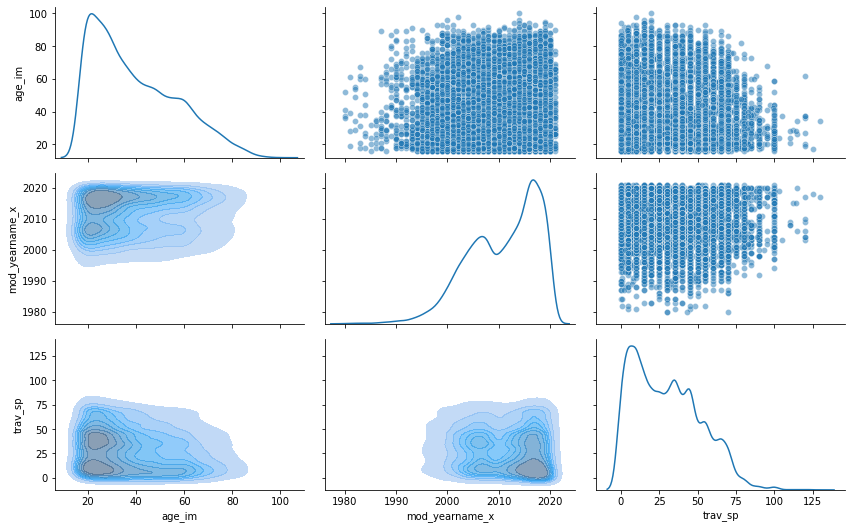

In [80]:
g = sns.PairGrid(num_feat, diag_sharey=False, aspect = 1.6);
g.map_upper(sns.scatterplot, alpha = 0.5);
g.map_lower(sns.kdeplot, shade=True, alpha = .6);
g.map_diag(sns.kdeplot);
# adapted code from https://seaborn.pydata.org/generated/seaborn.PairGrid.html

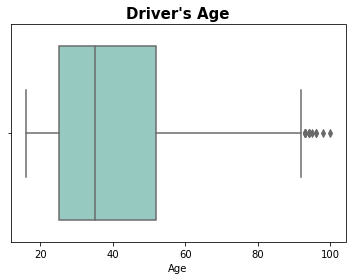

In [81]:
sns.boxplot(x=num_feat["age_im"], palette="Set3");
plt.xlabel('Age')
plt.title("Driver's Age", weight = 1000, fontsize=15);

Driver's age ranged from 16-100. We see a few outliers around 90 years old and above. The median age is 35 and mean age is around 40, makes sense as this is a right skewed distribution and the outliers will pull the mean towards it. The IQR, which encompasses the middle 50% of the data, is 27 years old.

In [82]:
num_feat.describe().T

,count,mean,std,min,25%,50%,75%,max
age_im,21650.0,39.374827,17.499861,16.0,25.0,35.0,52.0,100.0
mod_yearname_x,21650.0,2010.855427,6.785712,1980.0,2006.0,2012.0,2017.0,2021.0
trav_sp,21650.0,30.202587,21.738828,0.0,10.0,30.0,45.0,130.0


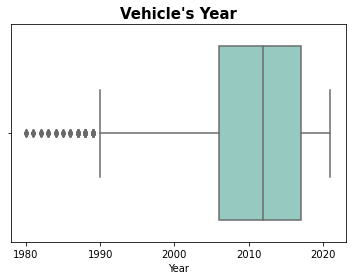

In [83]:
sns.boxplot(x=num_feat["mod_yearname_x"], palette="Set3");
plt.xlabel('Year')
plt.title("Vehicle's Year", weight = 1000, fontsize=15);

Vehicle's year depicted a left skewed distribution, ranging from 1980-2021 (we will note that years greater than 1980 were filered out). We see quite a bit of outliers after 1990. The median year is 2012 and mean year is around 2010. The IQR, which encompasses the middle 50% of the data, is 11 years.

In [84]:
num_feat.describe().T

,count,mean,std,min,25%,50%,75%,max
age_im,21650.0,39.374827,17.499861,16.0,25.0,35.0,52.0,100.0
mod_yearname_x,21650.0,2010.855427,6.785712,1980.0,2006.0,2012.0,2017.0,2021.0
trav_sp,21650.0,30.202587,21.738828,0.0,10.0,30.0,45.0,130.0


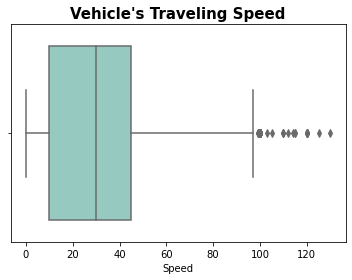

In [85]:
sns.boxplot(x=num_feat["trav_sp"], palette="Set3");
plt.xlabel('Speed')
plt.title("Vehicle's Traveling Speed", weight = 1000, fontsize=15);

Vehicle's traveling speed ranged from 0-130 mph. We see a number of outliers around 100 mph and greater. The median and mean speed is both 30, which is what we would expect. It would be interesting to revisit the statistic summary after removing the outliers. The IQR, which encompasses the middle 50% of the data, is 35 mph.

In [86]:
num_feat.describe().T

,count,mean,std,min,25%,50%,75%,max
age_im,21650.0,39.374827,17.499861,16.0,25.0,35.0,52.0,100.0
mod_yearname_x,21650.0,2010.855427,6.785712,1980.0,2006.0,2012.0,2017.0,2021.0
trav_sp,21650.0,30.202587,21.738828,0.0,10.0,30.0,45.0,130.0


In [87]:
train_df["trav_sp_scaled"] = train_pp_df.trav_sp_scaled.to_numpy()

## Modeling and Evaluation 1

### KMeans

In this section, we will search for optimal hyperparameters in both the KMeans Algorithm and MiniBatch KMeans for clustering on the continuous variables Travel Speed, Age of Driver and Age of Car

> For KMeans, there are three hyperparameters being tuned:
>> 1. The centroid initializers (k-means++ or random)
>>2. The number of times the algorithm is run with different centroid seeds
>>3. The number of clusters.

>For MiniBatch KMeans, there are three hyperparameters being tuned:
>>1. The centroid initalizers (k-means++ or random)
>>2. The number of batches for each run
>>3. The number of clusters.

> For both algorithms, we will use Inertia as the metric for evaluation and comparing in Modeling and Evaluation 2

In [88]:
#x=train_pp_df.drop("maxsev_binned",axis=1)
#xx=train_pp_df[['age_im','mod_yearname_x',"maxsev_binned"]] trav_sp
xx=train_df[['mod_yearname_x','age_im','trav_sp_scaled']]

In [91]:
##Tuning MiniBatch Hyperparameters

#%%capture minibatch_kmean_time

%%time
import warnings
warnings.filterwarnings("ignore")
kmini_intertias = [] 
inits=['k-means++', 'random']
batch=[1024,1500,3000,8000]
for i in range(2, 30):
    for x in inits:
        for y in batch:
            kmeans_mini = MiniBatchKMeans(n_clusters = i, random_state =42,init=x,batch_size=y)
            kmeans_mini.fit(xx)
            temp=[i,x,kmeans_mini.inertia_,y]
            kmini_intertias.append(temp)
kmini_inertias=pd.DataFrame(kmini_intertias,columns=['n_clusters','init','inertia','batch'])    


UsageError: Line magic function `%%time` not found.


In [90]:
##Tuning KMeans Hyperparameters

%%capture kmean_time
%%time
from sklearn.cluster import KMeans
kmeans_inertia=[]
inits=['k-means++', 'random']
n_inits=[10,50]
for i in range(1,30):
    for x in inits:
        for y in n_inits:
            K_means=KMeans(n_clusters=i,random_state=42,init=x,n_init=y)
            K_means.fit(xx)
            temp=[i,x,y,K_means.inertia_]
            kmeans_inertia.append(temp)
kmeans_inertia=pd.DataFrame(kmeans_inertia,columns=['n_clusters','init','n_init','inertia'])

UsageError: Line magic function `%%capture` not found.


>>### These are the results from the tail of the dataframes storing the hyperparameter tunings:

In [92]:
from IPython.display import display_html
print(" KMeans:",kmean_time,"\n","MiniBatch KMeans:",minibatch_kmean_time )
css_kmeans = kmeans_inertia.tail(n=10).style.set_table_attributes("style='display:inline'").set_caption('KMeans')
css_mini = kmini_inertias.tail(n=10).style.set_table_attributes("style='display:inline'").set_caption('MiniBatch KMeans')
 
display_html(css_kmeans._repr_html_()+css_mini._repr_html_(), raw=True)

NameError: name 'kmean_time' is not defined

### DBSCAN

In [99]:
from sklearn.neighbors import NearestNeighbors

In [97]:
#c_df = pd.read_csv("./preprocessed_train_07302022.csv")
cluster_df = train_pp_df.loc[:, ["age_im", "mod_yearname_x", "trav_sp_scaled", "maxsev_binned"]]
cluster_df.head(2)

,age_im,mod_yearname_x,trav_sp_scaled,maxsev_binned
0,-0.318745,1.20936,1.170987,Not Fatal
1,-0.831468,1.20936,-0.052825,Not Fatal


In [100]:
NUM_NEIGHBORS = 7

nearest_neighbor = NearestNeighbors(n_neighbors=NUM_NEIGHBORS)

X = cluster_df.loc[:, ["age_im", "mod_yearname_x", "trav_sp_scaled"]]

nearest_neighbor.fit(X)

# Calculate the top two closest nearest neighbors for all points
neighbor_distances, neighbor_indices = nearest_neighbor.kneighbors(X)

# Closest nearest naighbor is stored in column 0, however closest neighbor for a point will almost always
# be itself, the only exception being for cases where two points are exactly on top of eachother.
# The closest neighbor for a point, gaurenteed to not be itself, is stored in column 1.
#
first_nearest_neighbor_distance = neighbor_distances[:,0]    # Distance from each point to first nearest neighbor (dist to itself or point on top of itself). Always a list of all zeros
first_nearest_neighbor_indicies = neighbor_indices[:,0]      # Index of a points first nearest neighbor, will be index of itself unless another point is on top of itself
second_nearest_neighbor_distance = neighbor_distances[:,1]   # Distance to points second nearest neighbor. Will be distance to closest point not itself, except when points on top of eachother
second_nearest_neighbor_indicies = neighbor_indices[:,1]     # Index of pts second nearest neighbor. If this index is itself, then we know two points stacked (first nearest not self).

third_nearest_neighbor_distance = neighbor_distances[:,2]
third_nearest_neighbor_indicies = neighbor_indices[:,2]
fourth_nearest_neighbor_distance = neighbor_distances[:,3]
fourth_nearest_neighbor_indicies = neighbor_indices[:,3]
fifth_nearest_neighbor_distance = neighbor_distances[:,4]
fifth_nearest_neighbor_indicies = neighbor_indices[:,4]
sixth_nearest_neighbor_distance = neighbor_distances[:,5]
sixth_nearest_neighbor_indicies = neighbor_indices[:,5]
seventh_nearest_neighbor_distance = neighbor_distances[:,6]
seventh_nearest_neighbor_indicies = neighbor_indices[:,6]


# List of tuples. Each tuple contains three items
# 1) index of the point, 2) index of the points nearest neighbor, 3) distance between the point and its nearest neighbor
all_first_neighbor_distances = [(self_ind, neighbor_ind, neighbor_dist) for self_ind, neighbor_ind, neighbor_dist in
                                zip(cluster_df.index.to_numpy(), first_nearest_neighbor_indicies, first_nearest_neighbor_distance)]

# Sort the all_first_neighbor_distances list smallest to largest by nearest neighbor distance
sorted_first_neighbor_distances = sorted(all_first_neighbor_distances, key=lambda sublist: sublist[2])

# This list will have distances from each point to its nearest neighbor not itself, except in cases where two points are stacked on top of eachother.
# List of tuples. Each tuple contains three items
# 1) index of the point, 2) index of the points second nearest neighbor, 3) distance between the point and its second nearest neighbor
all_second_neighbor_distances = [(self_ind, neighbor_ind, neighbor_dist) for self_ind, neighbor_ind, neighbor_dist in
                                zip(cluster_df.index.to_numpy(), second_nearest_neighbor_indicies, second_nearest_neighbor_distance)]

# Sort the all_first_neighbor_distances list smallest to largest by second nearest neighbor distance
sorted_second_neighbor_distances = sorted(all_second_neighbor_distances, key=lambda sublist: sublist[2])


all_third_neighbor_distances = [(self_ind, neighbor_ind, neighbor_dist) for self_ind, neighbor_ind, neighbor_dist in
                                zip(cluster_df.index.to_numpy(), third_nearest_neighbor_indicies, third_nearest_neighbor_distance)]
sorted_third_neighbor_distances = sorted(all_third_neighbor_distances, key=lambda sublist: sublist[2])


all_fourth_neighbor_distances = [(self_ind, neighbor_ind, neighbor_dist) for self_ind, neighbor_ind, neighbor_dist in
                                zip(cluster_df.index.to_numpy(), fourth_nearest_neighbor_indicies, fourth_nearest_neighbor_distance)]
sorted_fourth_neighbor_distances = sorted(all_fourth_neighbor_distances, key=lambda sublist: sublist[2])

all_fifth_neighbor_distances = [(self_ind, neighbor_ind, neighbor_dist) for self_ind, neighbor_ind, neighbor_dist in
                                zip(cluster_df.index.to_numpy(), fifth_nearest_neighbor_indicies, fifth_nearest_neighbor_distance)]
sorted_fifth_neighbor_distances = sorted(all_fifth_neighbor_distances, key=lambda sublist: sublist[2])

all_sixth_neighbor_distances = [(self_ind, neighbor_ind, neighbor_dist) for self_ind, neighbor_ind, neighbor_dist in
                                zip(cluster_df.index.to_numpy(), sixth_nearest_neighbor_indicies, sixth_nearest_neighbor_distance)]
sorted_sixth_neighbor_distances = sorted(all_sixth_neighbor_distances, key=lambda sublist: sublist[2])

all_seventh_neighbor_distances = [(self_ind, neighbor_ind, neighbor_dist) for self_ind, neighbor_ind, neighbor_dist in
                                zip(cluster_df.index.to_numpy(), seventh_nearest_neighbor_indicies, seventh_nearest_neighbor_distance)]
sorted_seventh_neighbor_distances = sorted(all_seventh_neighbor_distances, key=lambda sublist: sublist[2])

SEVERITY_COLUMN = "maxsev_binned"

first_nearest_index_compare = ["Nearest Neighbor Is Self" if ind1 == ind2 else "Nearest Neighbor NOT Self\nbut is same severity" if
                               cluster_df.loc[cluster_df.index == ind1, SEVERITY_COLUMN].to_numpy()[0] == cluster_df.loc[cluster_df.index == ind2, SEVERITY_COLUMN].to_numpy()[0] else 
                                "Nearest Neighbor NOT Self\nand NOT same severity" for ind1, ind2 in zip(cluster_df.index.to_numpy(), first_nearest_neighbor_indicies)]

second_nearest_index_compare = ["Second Nearest Neighbor\nIs Self" if ind1 == ind2 else "Second Nearest Neighbor\nis NOT Self" for 
                               ind1, ind2 in zip(cluster_df.index.to_numpy(), second_nearest_neighbor_indicies)]

third_nearest_index_compare = ["Third Nearest Neighbor\nIs Self" if ind1 == ind2 else "Third Nearest Neighbor\nis NOT Self" for 
                               ind1, ind2 in zip(cluster_df.index.to_numpy(), third_nearest_neighbor_indicies)]

fourth_nearest_index_compare = ["Fourth Nearest Neighbor\nIs Self" if ind1 == ind2 else "Fourth Nearest Neighbor\nis NOT Self" for 
                               ind1, ind2 in zip(cluster_df.index.to_numpy(), fourth_nearest_neighbor_indicies)]

fifth_nearest_index_compare = ["Fifth Nearest Neighbor\nIs Self" if ind1 == ind2 else "Fifth Nearest Neighbor\nis NOT Self" for 
                               ind1, ind2 in zip(cluster_df.index.to_numpy(), fifth_nearest_neighbor_indicies)]

sixth_nearest_index_compare = ["Sixth Nearest Neighbor\nIs Self" if ind1 == ind2 else "Sixth Nearest Neighbor\nis NOT Self" for 
                               ind1, ind2 in zip(cluster_df.index.to_numpy(), sixth_nearest_neighbor_indicies)]

seventh_nearest_index_compare = ["Seventh Nearest Neighbor\nIs Self" if ind1 == ind2 else "Seventh Nearest Neighbor\nis NOT Self" for 
                               ind1, ind2 in zip(cluster_df.index.to_numpy(), seventh_nearest_neighbor_indicies)]


all_nearest_index_compare = first_nearest_index_compare + second_nearest_index_compare + third_nearest_index_compare + \
                                fourth_nearest_index_compare + fifth_nearest_index_compare + sixth_nearest_index_compare + seventh_nearest_index_compare


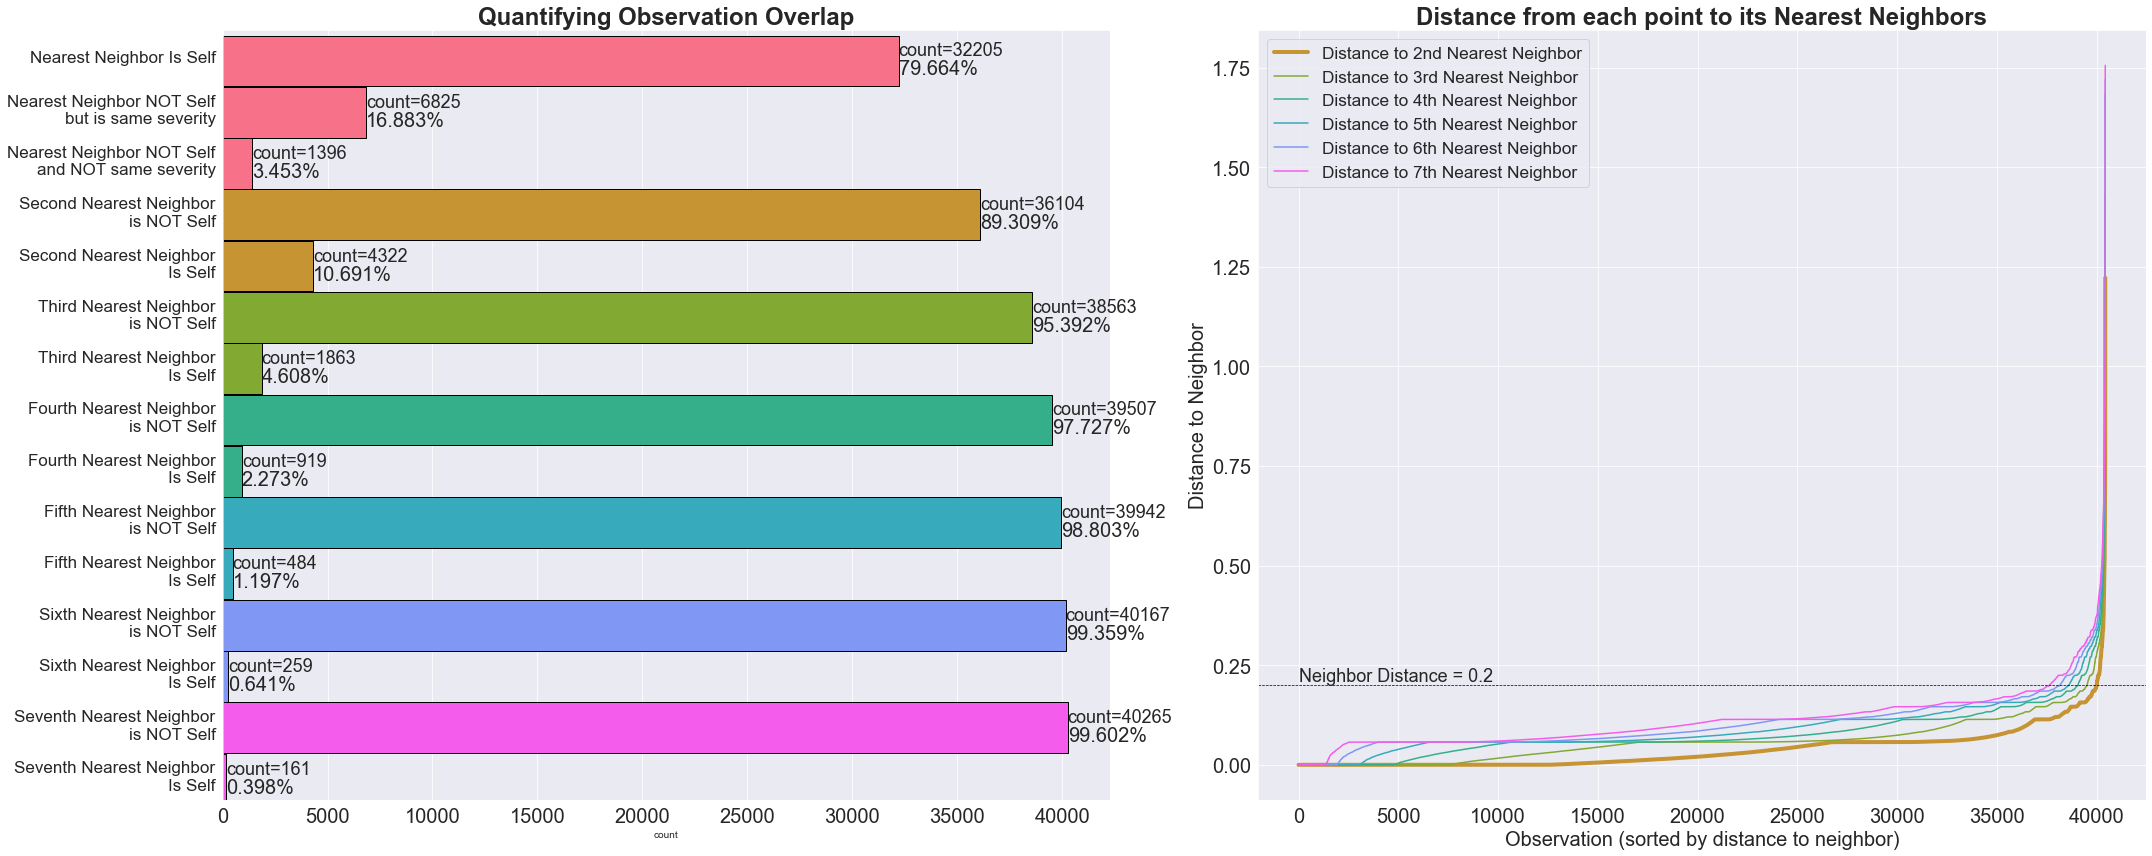

In [101]:
TOTAL_OBSERVATIONS = cluster_df.shape[0]
HORIZONTAL_BAR_HEIGHT = 0.99
ANNOT_HORZ_SHIFT = 0.02
MAX_CURVATURE_LINE_HEIGHT = 0.20

sns.set_style("darkgrid")

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 12), squeeze=True)

sns.countplot(y=all_nearest_index_compare, orient="h", ax=ax[0])

color_pal = sns.color_palette(palette="husl", n_colors=NUM_NEIGHBORS)
color_index = 0
for index, bar in enumerate(ax[0].patches):
    
    if index > 2 and index % 2 != 0:
        color_index += 1
    bar.set_color(c=color_pal[color_index])
    bar.set(edgecolor="black")
    
    bar.set_height(HORIZONTAL_BAR_HEIGHT)
    prop = bar.get_width() / TOTAL_OBSERVATIONS                       # percent of all observations this bar accounts for, as a decimal
    pct = f"{prop*100:.3f}%"                                          # formatted string showing percent of all observations this bar accounts for
    x = bar.get_x() + bar.get_width()                                 # calculate the x coord for the percentage annotation
    y = bar.get_y() + (bar.get_height() * (6/8)) + ANNOT_HORZ_SHIFT   # calculate the y coord for the percentage annotation
    ax[0].annotate(pct, (x,y), fontsize=20)                           # annotate the bar, indicating the percentage of observations the bar accounts for
    y = bar.get_y() + (bar.get_height() * (3/8)) + ANNOT_HORZ_SHIFT
    ax[0].annotate(f"count={round(prop*TOTAL_OBSERVATIONS)}", (x,y), fontsize=18)

ax[0].set_title("Quantifying Observation Overlap", fontsize=24, weight="bold")
ax[0].tick_params(axis="y", labelsize=17)
ax[0].tick_params(axis="x", labelsize=20)

ax[1].plot([dist for ind1, ind2, dist in sorted_second_neighbor_distances], color=color_pal[1], linewidth=4)
ax[1].plot([dist for ind1, ind2, dist in sorted_third_neighbor_distances], color=color_pal[2])
ax[1].plot([dist for ind1, ind2, dist in sorted_fourth_neighbor_distances], color=color_pal[3])
ax[1].plot([dist for ind1, ind2, dist in sorted_fifth_neighbor_distances], color=color_pal[4])
ax[1].plot([dist for ind1, ind2, dist in sorted_sixth_neighbor_distances], color=color_pal[5])
ax[1].plot([dist for ind1, ind2, dist in sorted_seventh_neighbor_distances], color=color_pal[6])
ax[1].legend(["Distance to 2nd Nearest Neighbor", 
              "Distance to 3rd Nearest Neighbor", 
              "Distance to 4th Nearest Neighbor", 
              "Distance to 5th Nearest Neighbor", 
              "Distance to 6th Nearest Neighbor", 
              "Distance to 7th Nearest Neighbor"], 
             loc="upper left", 
             fontsize="xx-large")
ax[1].axhline(y=MAX_CURVATURE_LINE_HEIGHT, xmin=0, xmax=1, linestyle="--", color="black", linewidth=0.7)
ax[1].annotate(f"Neighbor Distance = {MAX_CURVATURE_LINE_HEIGHT}", (0,MAX_CURVATURE_LINE_HEIGHT+0.01), fontsize=18)
ax[1].set_title("Distance from each point to its Nearest Neighbors", fontsize=24, weight="bold")
ax[1].set_xlabel("Observation (sorted by distance to neighbor)", fontsize=20)
ax[1].set_ylabel("Distance to Neighbor", fontsize=20)
ax[1].tick_params(axis="both", labelsize=20)
plt.tight_layout()

In [102]:
cluster_df.loc[(cluster_df["age_im"]==0.6507452253733584) & (cluster_df["mod_yearname_x"]==0.6259292179814554) & (cluster_df["trav_sp_scaled"]==-0.9295563589853442),:]

,age_im,mod_yearname_x,trav_sp_scaled,maxsev_binned


In [ ]:
def print_cluster_info(cluster_labels, top_n=5, X=None):
    
    if len(np.unique(cluster_labels)) > 1 and X is not None:
        sil_score = silhouette_score(X, cluster_labels)
    else:
        sil_score = None
    
    cluster_series = pd.Series(cluster_labels)
    cluster_summary = cluster_series.value_counts().describe()
    
    top_clusters_counts = cluster_series.value_counts().sort_values(ascending=False)[:top_n].to_numpy()
    top_clusters_pct = cluster_series.value_counts(normalize=True).sort_values(ascending=False)[:top_n]
    
    top_cluster_pcts = top_clusters_pct.to_numpy()
    top_cluster_labels = top_clusters_pct.index.to_numpy()
    
    print("==============================================================================================")
    print(f"Silhouette Score: {sil_score}")
    print(f"~~~~ Observations per cluster - Summary Stats ~~~~")
    print(f"Total Number of Clusters: {cluster_summary['count']}\n")
    print(f"Number of observations in smallest cluster: {cluster_summary['min']}")
    print(f"25th percentile cluster size: {cluster_summary['25%']}")
    print(f"Average number of observations per cluster: {cluster_summary['mean']}")
    print(f"75th percentile cluster size: {cluster_summary['75%']}\n~~~~\n")
    print(f"~~~~ Distribution of points in top {top_n} most populous clusters ~~~~")
    for label, pct, count in zip(top_cluster_labels, top_cluster_pcts, top_clusters_counts):
        print(f"Cluster Label: {label},    Cluster pct: {pct*100:.3f}%,    Cluster Observation Count:{count}")
    print("==============================================================================================\n")

CLUSTER_COLUMNS = ["age_im", "mod_yearname_x", "trav_sp_scaled"]

# https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf
# https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc#:~:text=DBSCAN%20works%20by%20determining%20whether,maximum%20distance%20between%20two%20points
X = cluster_df.loc[:, CLUSTER_COLUMNS]

# Using default min_samples is rarther boring for this data, everything is packed too close together... min_samples=5 makes it so
# everything is one big cluster

for min_samples in [5]:
    print(f">>>>> PERFORMING DBSCAN WITH MIN_SAMPLES={min_samples}  <<<<<")
    db_cluster = DBSCAN(eps=MAX_CURVATURE_LINE_HEIGHT, 
                        min_samples=min_samples)
    
    db_cluster.fit(X=X)
    print_cluster_info(cluster_labels=db_cluster.labels_, X=X)

>>>>> PERFORMING DBSCAN WITH MIN_SAMPLES=5  <<<<<


In [ ]:
'''
X = cluster_df.loc[:, CLUSTER_COLUMNS]

eps = np.linspace(start=0.15, stop=0.4, num=50).tolist()
min_samples = [num for num in range(5, 101)]

cluster_results = {"eps":[], 
                   "min_samples":[], 
                   "silhouette_score":[], 
                   "davies_bouldin_score":[],
                   "number_of_clusters":[], 
                   "min_cluster_size":[], 
                   "max_cluster_size":[], 
                   "mean_cluster_size":[], 
                   "cluster_size_75pct":[],
                   "cluster_size_25pct":[],
                   "total_noise_points":[]}

iteration=0
for ep in eps:
    for ms in min_samples:

        iteration+=1
        
        cluster = DBSCAN(eps=ep,
                         min_samples=ms, 
                         metric="euclidean", 
                         n_jobs=-1)


        cluster.fit(X=X)
        cluster_results["eps"].append(ep)
        cluster_results["min_samples"].append(ms)
        
        cluster_series = pd.Series(cluster.labels_)
        cluster_value_counts = cluster_series.value_counts()
        cluster_summary = cluster_value_counts.describe()
        num_clusters = cluster_summary['count']

        if num_clusters > 1:
            cluster_results["silhouette_score"].append(silhouette_score(X, cluster.labels_))
            cluster_results["davies_bouldin_score"].append(davies_bouldin_score(X, cluster.labels_))
        else:
            cluster_results["silhouette_score"].append(None)
            cluster_results["davies_bouldin_score"].append(None)
        
        cluster_results["number_of_clusters"].append(num_clusters)
        cluster_results["min_cluster_size"].append(cluster_summary['min'])
        cluster_results["max_cluster_size"].append(cluster_summary['max'])
        cluster_results["mean_cluster_size"].append(cluster_summary['mean'])
        cluster_results["cluster_size_75pct"].append(cluster_summary['75%'])
        cluster_results["cluster_size_25pct"].append(cluster_summary['25%'])
        
        if -1 in cluster_value_counts.index:
            cluster_results["total_noise_points"].append(cluster_value_counts[-1])
        else:
            cluster_results["total_noise_points"].append(0)''';

# UNCOMMENT
# dbscan_df = pd.DataFrame(cluster_results)

dbscan_df = pd.read_csv("./DBSCAN_MODELS_ITER2300.csv")

In [ ]:
dbscan_df.describe()

# Model and Evaluation 2
- Evaluate and compare  

### KMeans

> Now that we have our metric of Inertia for the various hyperparameter tunings, we will plot each one against the other below.  Discussion of the graphs will follow.

In [ ]:
##Plot Number of clusters vs Inertia for kmeans and minibatch kmeans
plt.clf() 
plt.figure(figsize=(10,10))
##Plots all minibatch kmeans and regular kmeans
for init in inits:
    for batches in batch:
        plt.plot(kmini_inertias.n_clusters.loc[(kmini_inertias.iloc[:,1]==init) & (kmini_inertias.iloc[:,3]==batches)], kmini_inertias.inertia.loc[(kmini_inertias.iloc[:,1]==init) & (kmini_inertias.iloc[:,3]==batches)])
for init in inits:
    for n in n_inits:
        plt.plot(kmeans_inertia.n_clusters.loc[(kmeans_inertia.iloc[:,1]==init) & (kmeans_inertia.iloc[:,2]==n)], kmeans_inertia.inertia.loc[(kmeans_inertia.iloc[:,1]==init) & (kmeans_inertia.iloc[:,2]==n)],color="black")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.suptitle("Kmeans and MiniBatch KMeans \n ME2.1")
plt.title("Number of Clusters vs. Inertia")
plt.axvline(8, linestyle='--', color='r')
plt.show()

print("----------------------------------------------------------------------------------------------")

##plot a local figure around the elbow point

plt.figure(figsize=(10,10))
for init in inits:
    for batches in batch:
        plt.plot(kmini_inertias.n_clusters.loc[(kmini_inertias.iloc[:,1]==init) & (kmini_inertias.iloc[:,3]==batches)], kmini_inertias.inertia.loc[(kmini_inertias.iloc[:,1]==init) & (kmini_inertias.iloc[:,3]==batches)],label=[init,batches])
for init in inits:
    for n in n_inits:
        plt.plot(kmeans_inertia.n_clusters.loc[(kmeans_inertia.iloc[:,1]==init) & (kmeans_inertia.iloc[:,2]==n)], kmeans_inertia.inertia.loc[(kmeans_inertia.iloc[:,1]==init) & (kmeans_inertia.iloc[:,2]==n)],color="black",label=[init,n])
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.suptitle("Local View of Elbow \n ME2.2")
plt.title("Number of Clusters vs. Inertia")
plt.xlim(7,9)
plt.ylim(30000,50000)
plt.xticks([7,8,9],)
plt.axvline(8, linestyle='--', color='r')
plt.legend()
plt.show()

### Summarizing the results for the graphs Number of Clusters vs Inertia.
> The top graph (ME2.1) shows all of the inertia vs cluster values for all KMeans and MiniBatch KMeans hyper parameter tuning. The legend has been excluded due to the close proximity of all the curves; however, a glance at the top graph suggests that different hyperparameters in both algorithms doesn't appear to affect the inertia score significantly. For reference, the non-black lines are all from MiniBatch KMeans while the black line is represents all of the KMean hyperparameter tunings.  The KMeans inertia score does not vary by an amount that can be visually seen in this range. The cell below show the tuning outputs at 8 clusters for KMeans.  It can be seen that the inertia score only changes by roughly 1 at 8 clusters and around 100-200 at 28 clusters.  We are focused on the 8 cluster range as it is the "elbow" in the graph.

> The bottom graph (ME2.2) provides a local view around our selection of 8 clusters. A legend has been provided for this graph, but again the KMeans Algorithm tunings are all colored in black as it continues to not be visual in this range. It is not surprising that KMeans produces a lower Inertia score than MiniBatch, but it is encouraging to see how close MiniBatch is to the full KMeans.  Given the low Wall Time and the slightly better performance, we have chosen to go ahead with the KMeans algorithm using 8 clusters, init = k-means++ and n_init = 10.  Please note that init and n_init are the default settings.  Since all of the KMeans algorithms produced nearly identical results, we have decided to go with the default settings for those 2 parameters while setting n_clusters = 8.

In [ ]:
kmeans_inertia.loc[(kmeans_inertia.n_clusters==8) | (kmeans_inertia.n_clusters==28)]

> Showing KMeans algorithm and minute differences in inertia

## DBSCAN

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(25, 20), squeeze=True)

MIN_SAMPLES = {"best":dbscan_df.loc[dbscan_df["silhouette_score"] == dbscan_df["silhouette_score"].max(), "min_samples"].to_numpy()[0], 
               "worst":dbscan_df.loc[dbscan_df["silhouette_score"] == dbscan_df["silhouette_score"].min(), "min_samples"].to_numpy()[0], 
               "default":5}

color_pal = sns.color_palette(palette="husl", n_colors=len(MIN_SAMPLES))
legend_list = []

for index, (min_samples_type, samples) in enumerate(MIN_SAMPLES.items()):
    
    plot_df = dbscan_df.loc[dbscan_df["min_samples"] == samples,:]
    ax[0].plot(plot_df["eps"], plot_df["silhouette_score"], color=color_pal[index])
    legend_list.append(f"{min_samples_type} Min Samples = {samples}")
    
    
ax[0].legend(legend_list,
             loc="upper left", 
             fontsize="medium")

ax[0].set_title(f"Silhouette Score vs DBSCAN EPS at various min_samples", fontsize=24, weight="bold")
ax[0].set_xlabel("EPS", fontsize=16)
ax[0].set_ylabel("Silhouette Score", fontsize=16)
ax[0].tick_params(axis="both", labelsize=14)


# MIDDLE PLOT
MIN_SAMPLES = dbscan_df.loc[dbscan_df["silhouette_score"] == dbscan_df["silhouette_score"].max(), "min_samples"].to_numpy()[0]

plot_df = dbscan_df.loc[dbscan_df["min_samples"] == MIN_SAMPLES,:]

ax[1].plot(plot_df["eps"], plot_df["silhouette_score"])
sns.scatterplot(x="eps", y="silhouette_score", hue="number_of_clusters", data=plot_df, legend="brief", palette="flare", s=120, ax=ax[1])


ax[1].set_title(f"Silhouette Score vs DBSCAN EPS at min_samples={MIN_SAMPLES} (best per silhouette)", fontsize=24, weight="bold")
ax[1].set_xlabel("EPS", fontsize=16)
ax[1].set_ylabel("Silhouette Score", fontsize=16)
ax[1].tick_params(axis="both", labelsize=14)

# BOTTOM PLOT
MIN_CLUSTERS=4
MIN_CLUSTER_25PCT = (0.05 * cluster_df.shape[0])

filters = (dbscan_df["number_of_clusters"] >= MIN_CLUSTERS) & (dbscan_df["cluster_size_25pct"] >= MIN_CLUSTER_25PCT)

db_subset_df =  dbscan_df.loc[filters, :]

MIN_SAMPLES = db_subset_df.loc[db_subset_df["silhouette_score"] == db_subset_df["silhouette_score"].max(), "min_samples"].to_numpy()[0]

plot_df = dbscan_df.loc[dbscan_df["min_samples"] == MIN_SAMPLES,:]

ax[2].plot(plot_df["eps"], plot_df["silhouette_score"])
sns.scatterplot(x="eps", y="silhouette_score", hue="number_of_clusters", data=plot_df, legend="brief", palette="flare", s=120, ax=ax[2])

title = (f"Silhouette Score vs DBSCAN EPS at min_samples={MIN_SAMPLES}\n" 
        f"(best per silhouette, when constrained to min_clusters={MIN_CLUSTERS}, min cluster 25th percentile={round(MIN_CLUSTER_25PCT)}")


ax[2].set_title(title, fontsize=20, weight="bold")
ax[2].set_xlabel("EPS", fontsize=16)
ax[2].set_ylabel("Silhouette Score", fontsize=16)
ax[2].tick_params(axis="both", labelsize=14)

plt.tight_layout()

In [ ]:
best_eps = dbscan_df.loc[dbscan_df["silhouette_score"] == dbscan_df["silhouette_score"].max(), "eps"].to_numpy()[0]
best_min_samples = dbscan_df.loc[dbscan_df["silhouette_score"] == dbscan_df["silhouette_score"].max(), "min_samples"].to_numpy()[0]

CLUSTER_COLUMNS = ["age_im", "mod_yearname_x", "trav_sp_scaled"]
X = cluster_df.loc[:, CLUSTER_COLUMNS]

print(f">>>>> PERFORMING DBSCAN WITH MIN_SAMPLES={best_min_samples} and EPS={best_eps}<<<<<")
db_cluster = DBSCAN(eps=best_eps, 
                        min_samples=best_min_samples)
    
db_cluster.fit(X=X)
print_cluster_info(cluster_labels=db_cluster.labels_, X=X)


best_eps_subset = db_subset_df.loc[db_subset_df["silhouette_score"] == db_subset_df["silhouette_score"].max(), "eps"].to_numpy()[0]
best_min_samples_subset = db_subset_df.loc[db_subset_df["silhouette_score"] == db_subset_df["silhouette_score"].max(), "min_samples"].to_numpy()[0]

CLUSTER_COLUMNS = ["age_im", "mod_yearname_x", "trav_sp_scaled"]
X = cluster_df.loc[:, CLUSTER_COLUMNS]

print(f">>>>> PERFORMING DBSCAN WITH MIN_SAMPLES={best_min_samples_subset} and EPS={best_eps_subset}<<<<<")
db_cluster_subset = DBSCAN(eps=best_eps_subset, 
                        min_samples=best_min_samples_subset)
    
db_cluster_subset.fit(X=X)

db_cluster_subset_labels = db_cluster_subset.labels_

print_cluster_info(cluster_labels=db_cluster_subset_labels, X=X)

# Model and Evaluation 3
- Visualize results  
> Since we are only clustering on 3 continuous variables, we have the benefit of being able to visualize our clusters more easily. There are 8 graphs for the KMeans clustering.  The first 3 rows of graphs represent a 2d slice of each feature plotted against the other.  The 1st and 2nd columns show a 180 degree rotation around the y-axis of the graphs. This allows us to see the clustering from the viewpoint of the minimum and maximum of the excluded feature.
The 4th row provides a 3d plot of the features to give the reader a better sense of how features interact in the clustering.

In [ ]:
##K-means that had the best results
kmeans_full = KMeans(n_clusters=8,random_state=42)
kmeans_full.fit_transform(xx)
train_df['kmeans_8']=kmeans_full.labels_


In [ ]:
##3d plotting

## This does an inverse transform on the continuous variables to put them back to their original values for plotting

yy=pd.DataFrame(scaler.inverse_transform(xx[['age_im','mod_yearname_x']]),columns=['age_im','mod_yearname_x'])
yy['trav_sp_scaled']=speed_scaler.inverse_transform(xx[['trav_sp_scaled']])
yy.mod_yearname_x=yy.mod_yearname_x-1980
from mpl_toolkits import mplot3d

##Plot 1 Driver Age vs Speed

fig = plt.figure(figsize=(40,40))
fig.suptitle("KMean (8) Clustering on Features", fontsize=55)

ax = fig.add_subplot(4, 2, 1, projection='3d')
ax.scatter3D(yy.iloc[:,0], yy.iloc[:,1], yy.iloc[:,2], c=kmeans_full.labels_, cmap=plt.cm.rainbow)
ax.set_xlabel("Driver Age")
ax.set_ylabel("")
ax.set_zlabel("Speed")

ax.set_yticks([])
ax.view_init(azim=270,elev=0)

##Plot 2 Driver Age vs Speed


ax = fig.add_subplot(4, 2, 2, projection='3d')
ax.scatter3D(yy.iloc[:,0], yy.iloc[:,1], yy.iloc[:,2], c=kmeans_full.labels_, cmap=plt.cm.rainbow)
ax.set_xlabel("Driver Age")
ax.set_ylabel("")
ax.set_zlabel("Speed")

ax.set_yticks([])
ax.view_init(azim=90,elev=0)

##plot 3 Car Age vs Speed

ax = fig.add_subplot(4, 2, 3, projection='3d')
ax.scatter3D(yy.iloc[:,0], yy.iloc[:,1], yy.iloc[:,2], c=kmeans_full.labels_, cmap=plt.cm.rainbow);
ax.set_xlabel("")
ax.set_ylabel("Car Age")
ax.set_zlabel("Speed")

ax.set_xticks([])
ax.view_init(azim=0,elev=0)

##Plot 4 Car Age vs Speed

ax = fig.add_subplot(4, 2, 4, projection='3d')
ax.scatter3D(yy.iloc[:,0], yy.iloc[:,1], yy.iloc[:,2], c=kmeans_full.labels_, cmap=plt.cm.rainbow);
ax.set_xlabel("")
ax.set_ylabel("Car Age")
ax.set_zlabel("Speed")

ax.set_xticks([])
ax.view_init(azim=180,elev=0)



##plot 5

ax = fig.add_subplot(4, 2, 5, projection='3d')
ax.scatter3D(yy.iloc[:,0], yy.iloc[:,1], yy.iloc[:,2], c=kmeans_full.labels_, cmap=plt.cm.rainbow);
ax.set_xlabel("Driver Age")
ax.set_ylabel("Car Age")
ax.set_zlabel("")

ax.set_zticks([])
ax.view_init(azim=270,elev=90)

##plot 6

ax = fig.add_subplot(4, 2, 6, projection='3d')
ax.scatter3D(yy.iloc[:,0], yy.iloc[:,1], yy.iloc[:,2], c=kmeans_full.labels_, cmap=plt.cm.rainbow);
ax.set_xlabel("Driver Age")
ax.set_ylabel("Car Age")
ax.set_zlabel("")

ax.set_zticks([])
ax.view_init(azim=90,elev=270)

#plot 7
ax = fig.add_subplot(4, 2, 7, projection='3d')
ax.scatter3D(yy.iloc[:,0], yy.iloc[:,1], yy.iloc[:,2], c=kmeans_full.labels_, cmap=plt.cm.rainbow);
ax.set_xlabel("Driver Age")
ax.set_ylabel("Car Age")
ax.set_zlabel("Speed")


#plot 7
ax = fig.add_subplot(4, 2, 8, projection='3d')
ax.scatter3D(yy.iloc[:,0], yy.iloc[:,1], yy.iloc[:,2], c=kmeans_full.labels_, cmap=plt.cm.rainbow);
ax.set_xlabel("Driver Age")
ax.set_ylabel("Car Age")
ax.set_zlabel("Speed")
ax.view_init(azim=135,elev=20)
plt.show()

## DBSCAN

In [ ]:
MIN_SAMPLES = 20
SEVERITY_COLUMN = "maxsev_binned"
X = cluster_df.loc[:, CLUSTER_COLUMNS]

db_cluster = DBSCAN(eps=MAX_CURVATURE_LINE_HEIGHT, 
                        min_samples=MIN_SAMPLES)
    
db_cluster.fit(X=X)

plot_df = cluster_df.loc[:, CLUSTER_COLUMNS + [SEVERITY_COLUMN]]
plot_df["Cluster"] = db_cluster_subset_labels

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(26, 8), squeeze=True)
plot_axis_columns = [("age_im", "trav_sp_scaled"),  ("mod_yearname_x","trav_sp_scaled")]
for index, (x_column, y_column) in enumerate(plot_axis_columns):
    sns.scatterplot(x=x_column, 
                    y=y_column, 
                    data=plot_df.loc[plot_df["Cluster"].isin([0, 1]), :], 
                    hue="Cluster", 
                    palette="husl", 
                    style=SEVERITY_COLUMN, 
                    alpha=0.5,
                    ax=ax[index], legend=False)
    
    sns.scatterplot(x=x_column, 
                    y=y_column, 
                    data=plot_df.loc[plot_df["Cluster"] ==2, :], 
                    s=20, 
                    c=["black"], 
                    ax=ax[index])
    
    ax[index].set_title(f"{y_column} vs {x_column}\nmarker shapes by collision severity level\nshaded by DBSCAN cluster (eps={best_eps_subset:.3f}, min_samples={best_min_samples_subset})", 
                        fontsize=18, 
                        weight="bold")
    ax[index].set_xlabel(f"{x_column.replace('_', ' ').title()}", fontsize=20)
    ax[index].set_ylabel(f"{y_column.replace('_', ' ').title()}", fontsize=20)
    ax[index].tick_params(axis="both", labelsize=14)
plt.tight_layout()

In [ ]:
px.scatter_3d(data_frame=cluster_df, 
              x="age_im", 
              y="trav_sp_scaled", 
              z="mod_yearname_x", 
              color=db_cluster_subset_labels,
              symbol=cluster_df[SEVERITY_COLUMN],
              opacity=0.5,
              height=500, 
              width=1000, 
              size_max=5)

# Model and Evaluation 4
- Summarize the ramifications  


In [ ]:
##Print out top features for each cluster
holder=pd.DataFrame()
for clust in range(0,8):
    holder=pd.concat([holder,train_df.loc[train_df['kmeans_8']==clust].describe(include="object")])
holder

# Deployment
- Be critical of your performance and tell the reader how you current model might be usable by other parties. 
- Did you achieve your goals? If not, can you reign in the utility of your modeling? 
- How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)? 
- How would your deploy your model for interested parties? 
- What other data should be collected? 
- How often would the model need to be updated, etc.?  
(10)

**Be critical of your performance and tell the reader how you current model might be usable by other parties.**

Words

**Did you achieve your goals? If not, can you reign in the utility of your modeling?**

Words

**How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?**

For this data, the goal of clustering is to understand how accident prevalence/severity is associated with driver demographics/behavior. Interested parties may be able to use this model to predict fatal accidents in real time, gauge the cost of car insurance quotes, or recognize overall driver tendencies to *drive* policy changes / public awareness (pun intended).

**How would your deploy your model for interested parties?**

Model deployment would be in some visual form, perhabs on Tableau for leadership and public consumption. The model could be deployed as a risk map to visualize crash density in the US.

**What other data should be collected?**

Historical data can be used to identify high-risk areas or times to predict future fatal accidents. GPS data could be collected to obtain a more granular understanding of at-risk locations. Additional location, traffic, or accident data could be collected in conjunction. 

**How often would the model need to be updated, etc.?**

Because this is an inferential model, it does not need to be updated as often, though on a quarterly basis is ideal.



# Exceptional Work
- You have free reign to provide additional analyses or combine analyses.  
(10)

[Here is the link to the Tableau dashboard for this data.](https://public.tableau.com/app/profile/hien4920/viz/CrashAccidentStatistics/dashboard) 

On the first row is a barplot of accident severity and a histogram of ages (binned). The slicers on the right side of the page will populate this row so the user can see how the distribution of accident severity and age change depending on the features. This is a nod to our feature selection methods conducted in previous labs where we found that sex, alcohol status, speeding status, and restraint use were the most important. On the second row is a highlight tables of accident severity by day, time of day, and region. The third row is a highlight table in a much more granular view. Here, the user can discern how the median age of driver differed when accouting for gender, speeding status, and *alcohol status* vs. gender, speeding status, and *restraint use*. We highlighted median age due to its right skewed distribution but the user can also view the mean age if they hover over table.

Some high level observations:
1. Approximately 15% of all accidents result in fatality.
2. Driver's age is right skewed with mode around 25 years old.
3. Our intuition tells us that most fatalities would occur on weekends but Wednesday makes a surprise appearance. Sundays have the least amount of accidents is intriuging but 20% resulted in fatality. 
4. Evening has the most amount of accidents and fatality makes sense to us. Morning has more fatalities than afternoon despite less accidents. 
5. The southern region has more total accidents yet similar fatality rate as midwest and northeast at 14% compared to the western region with 18%.
6. The median age of the driver when speeding is the same (and youngest!) regardless of gender or alcohol use at the time of accident. The median age of drivers with alcohol use during time of accident is younger than those who did not have alcohol in their system. Males have a higher median age than their female counterpart when not speeding, regardless of alcohol use. This makes sense to us as males are more reckless. 
7. The median age of the driver when speeding is the same (and youngest!) regardless of gender or restraint use at the time of accident. Males have a higher median age than their female counterpart when not speeding, regardless of restraint use. This makes sense to us as males are more reckless.

# Appendix
Data dictionary referenced from [CRSS Analytical Users Manual](https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/813236)